# **-------------- Classification ---------------**

In [2]:
import logging

# Remove all handlers associated with the root logger (Jupyter attaches its own by default)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Reconfigure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info("Logger is now configured correctly.")


2025-05-09 13:04:16,585 - INFO - Logger is now configured correctly.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

logger.info("All libraries for Classification imported successfully.")


2025-05-09 13:04:17,164 - INFO - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-05-09 13:04:17,164 - INFO - NumExpr defaulting to 8 threads.
2025-05-09 13:04:24,630 - INFO - All libraries for Classification imported successfully.


## **Data Cleaning**

In [ ]:
df = pd.read_csv("/content/clinically_validated_balanced_disease_data.csv")

logger.info("Data has been read from CSV file.")

2025-05-09 13:04:24,797 - INFO - Data has been read from CSV file.


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 35 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Gender                                            30000 non-null  object 
 1   Age                                               30000 non-null  int64  
 2   Hemoglobin (g/dL)                                 30000 non-null  float64
 3   RBC (million/µL)                                  30000 non-null  float64
 4   Platelet Count (platelets/µL)                     30000 non-null  float64
 5   Fasting Blood Sugar (mg/dL)                       30000 non-null  float64
 6   Hemoglobin A1C (%)                                30000 non-null  float64
 7   Serum Creatinine (mg/dL)                          30000 non-null  float64
 8   Blood Urea Nitrogen (BUN) (mg/dL)                 30000 non-null  float64
 9   Glomerular Filtra

Remove duplicates

In [6]:
duplicate_count = df.duplicated().sum()
print(f"Found {duplicate_count} duplicate rows.")
df.drop_duplicates(inplace=True)

Found 0 duplicate rows.


Label encoding

In [7]:
gender_mapping = {'Men': 0, 'Women': 1, 'Children': 2}
df['Gender'] = df['Gender'].map(gender_mapping)

In [8]:
protein_glucose_mapping = {'Absent': 0, 'Trace': 1}
df['Urine Protein'] = df['Urine Protein'].map(protein_glucose_mapping)
df['Urine Glucose'] = df['Urine Glucose'].map(protein_glucose_mapping)

Remove nulls

In [9]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [10]:
df.head(10)

,Gender,Age,Hemoglobin (g/dL),RBC (million/µL),Platelet Count (platelets/µL),Fasting Blood Sugar (mg/dL),Hemoglobin A1C (%),Serum Creatinine (mg/dL),Blood Urea Nitrogen (BUN) (mg/dL),Glomerular Filtration Rate (GFR) (mL/min/1.73m²),...,MCV (fL),Troponin I (ng/mL),Albumin (g/dL),Globulin (g/dL),Albumin/Globulin Ratio,Diabetes,Anemia,Kidney Failure,Liver Failure,Ischimic Heart Disease
0,1,69,14.257371,8.862371,57357.373916,105.827393,7.985060,0.197273,6.600803,138.202441,...,117.419127,0.019176,2.709012,3.044257,1.248143,1,0,0,1,0
1,1,19,15.167603,7.381710,50000.000000,103.081681,5.743709,0.822036,6.332702,107.629438,...,78.226165,0.000000,5.869840,5.000000,1.721615,0,1,0,0,0
2,1,69,14.871775,5.488027,291284.245975,68.446665,9.160892,0.194298,16.543115,132.871783,...,91.823393,0.034993,5.869036,1.320341,5.438891,1,1,0,0,1
3,1,36,7.430936,7.628546,294007.378888,108.026413,3.323265,0.351908,6.124054,141.337023,...,94.354484,0.000000,2.108488,5.000000,0.749355,0,1,0,1,0
4,0,75,14.916126,5.584631,50000.000000,100.009117,3.026879,0.775227,23.038206,88.031083,...,95.242320,36.252397,2.350525,2.121274,1.775994,0,1,1,1,1
5,1,28,11.710747,9.691712,746375.630382,500.249017,3.754828,0.692813,16.046459,120.178701,...,66.355931,0.014995,2.919955,2.539225,1.149940,1,1,0,0,1
6,2,1,17.694037,5.493998,65903.796641,60.858264,5.044203,0.195622,14.512448,200.005681,...,61.367311,0.039417,2.438083,1.787484,2.013596,0,0,0,0,1
7,0,36,16.885076,4.322582,295371.257980,79.519518,10.316065,1.163002,35.780376,76.583849,...,83.561171,0.000000,4.036577,4.180278,1.315865,1,0,1,0,1
8,1,75,7.670464,4.806064,827425.395289,60.761264,3.329877,2.852325,6.880491,16.269428,...,60.267795,18.220230,5.363494,1.105243,4.852772,0,1,1,0,1
9,0,24,16.087634,2.288259,282408.688033,64.871544,3.889383,0.789307,23.348978,121.180588,...,95.048887,0.001437,4.783365,2.901774,2.796289,1,0,0,0,0


Splitting Data (Early Splitting to avoid data Leakage)

In [11]:
# Log before splitting
logger.info("Data is cleaned. Proceeding to train-test split...")

target_columns = ['Diabetes', 'Anemia', 'Kidney Failure', 'Liver Failure', 'Ischimic Heart Disease']
X = df.drop(columns=target_columns)
y = df[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log after splitting
logger.info("Data has been split into training and testing sets.")

2025-05-09 13:04:24,985 - INFO - Data is cleaned. Proceeding to train-test split...
2025-05-09 13:04:24,998 - INFO - Data has been split into training and testing sets.


Handeling Outliers

In [12]:
for col in X_train.columns:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train[col] = np.clip(X_train[col], lower_bound, upper_bound)
    X_test[col] = np.clip(X_test[col], lower_bound, upper_bound)
logger.info("Outliers are removed from Train data")

2025-05-09 13:04:25,079 - INFO - Outliers are removed from Train data


#### Feature Selection

In [13]:
mi_scores = pd.DataFrame({target: mutual_info_classif(X_train, y_train[target], discrete_features=False) for target in target_columns}, index=X_train.columns)
mi_scores["Average_Score"] = mi_scores.mean(axis=1)
selected_features = mi_scores[mi_scores["Average_Score"] >= 0.001].index.tolist()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

logger.info("Important Features are Selected")

2025-05-09 13:04:35,564 - INFO - Important Features are Selected


#### Feature Scaling

In [14]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=selected_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=selected_features)

logger.info("Features are Scaled")

2025-05-09 13:04:35,584 - INFO - Features are Scaled


#### Data visualization Before Scaling

<Figure size 1600x1000 with 0 Axes>

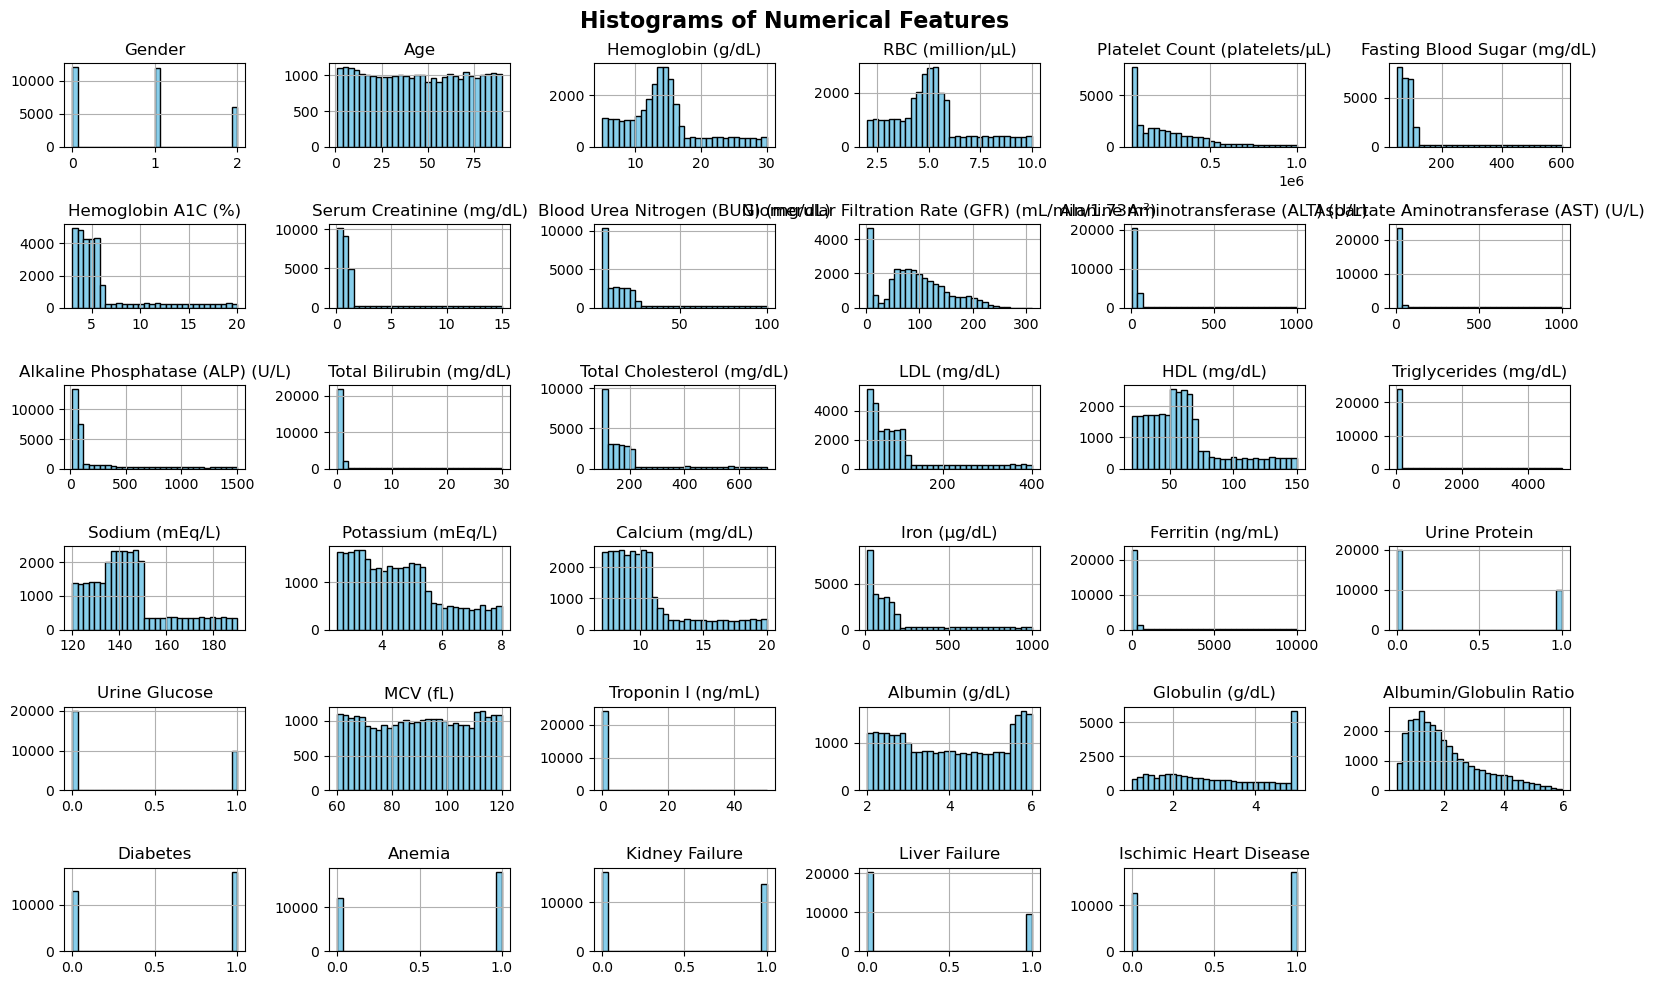

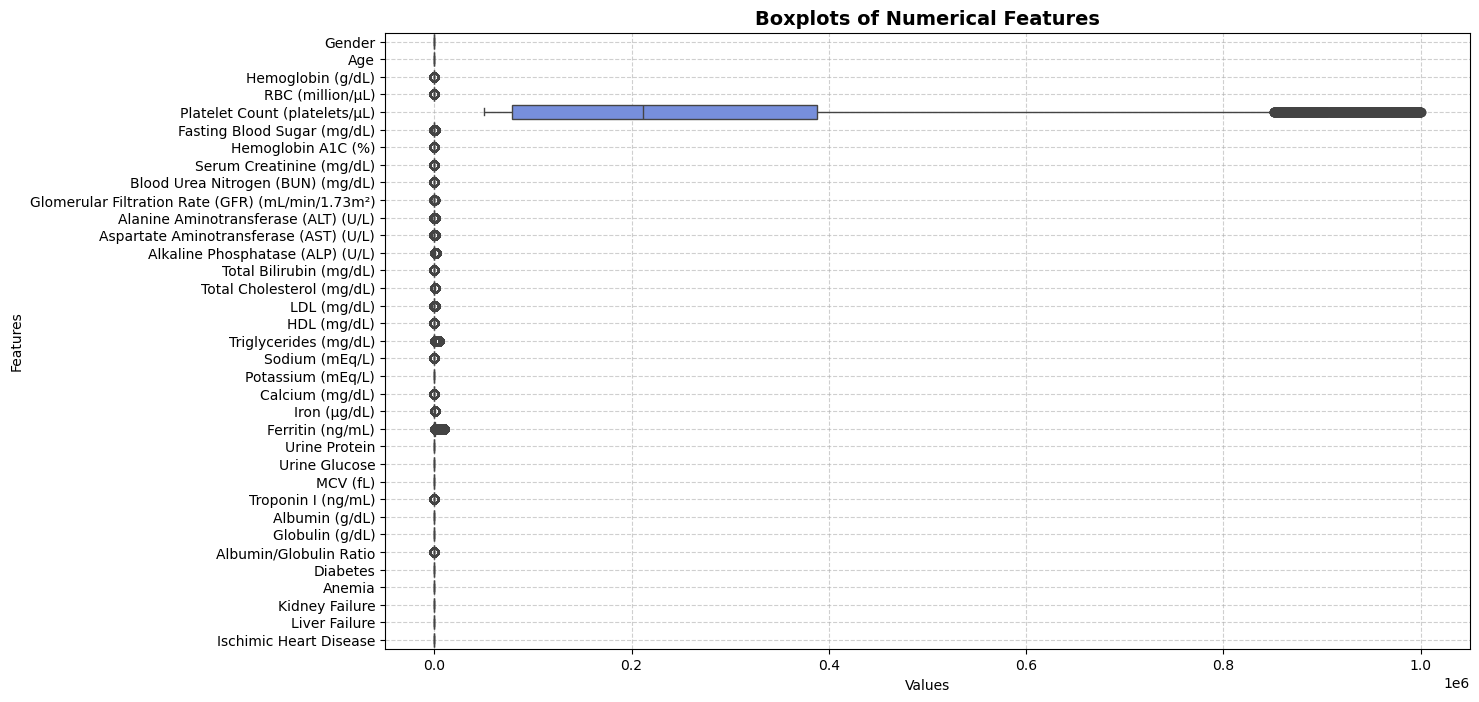

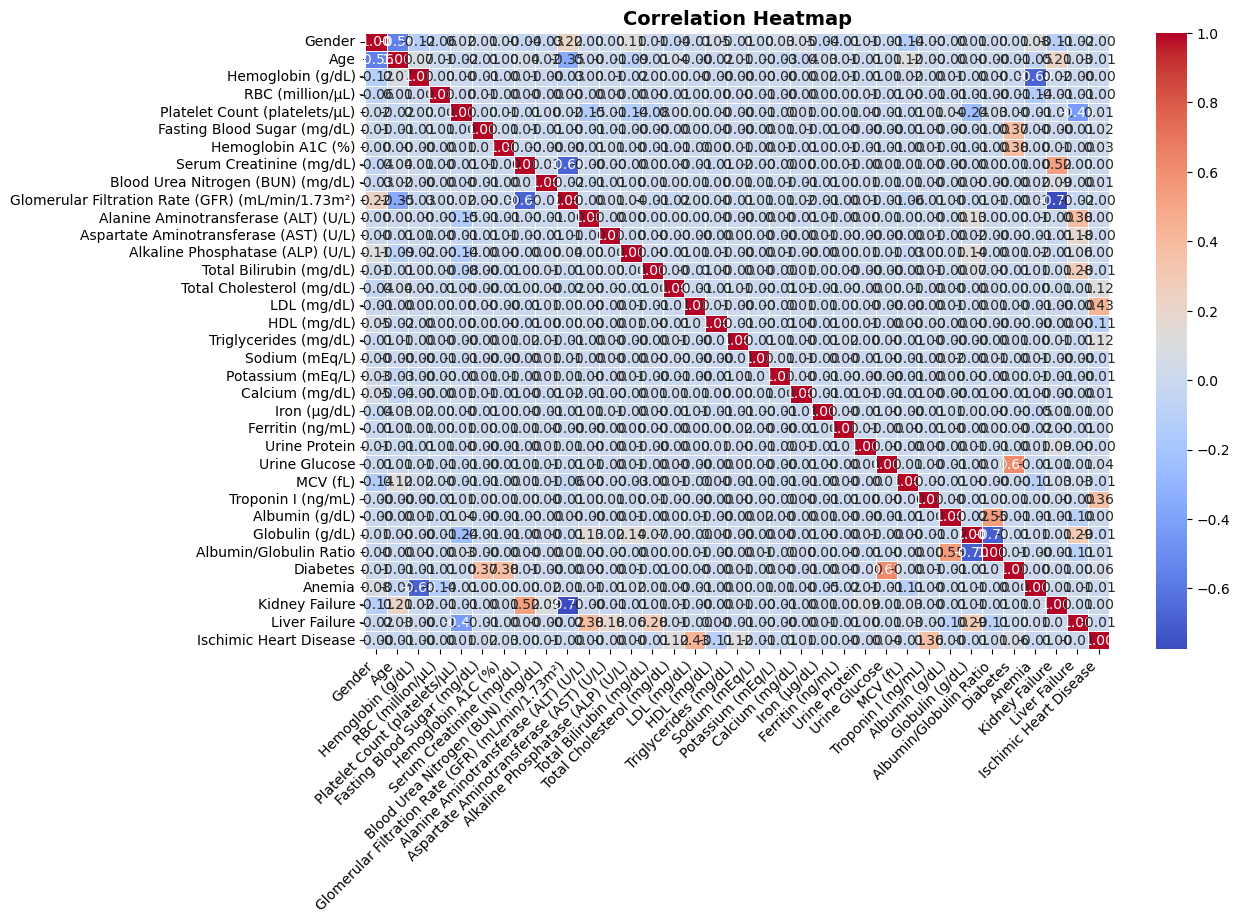

In [15]:
num_df = df.select_dtypes(include=['number'])

#histograms
plt.figure(figsize=(16, 10))
num_df.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=num_df, orient='h', palette="coolwarm")
plt.title("Boxplots of Numerical Features", fontsize=14, fontweight='bold')
plt.xlabel("Values")
plt.ylabel("Features")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


#heatmap
plt.figure(figsize=(12, 8))
corr_matrix = num_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Correlation Heatmap", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

#### Data Visualization After Scaling

<Figure size 1600x1000 with 0 Axes>

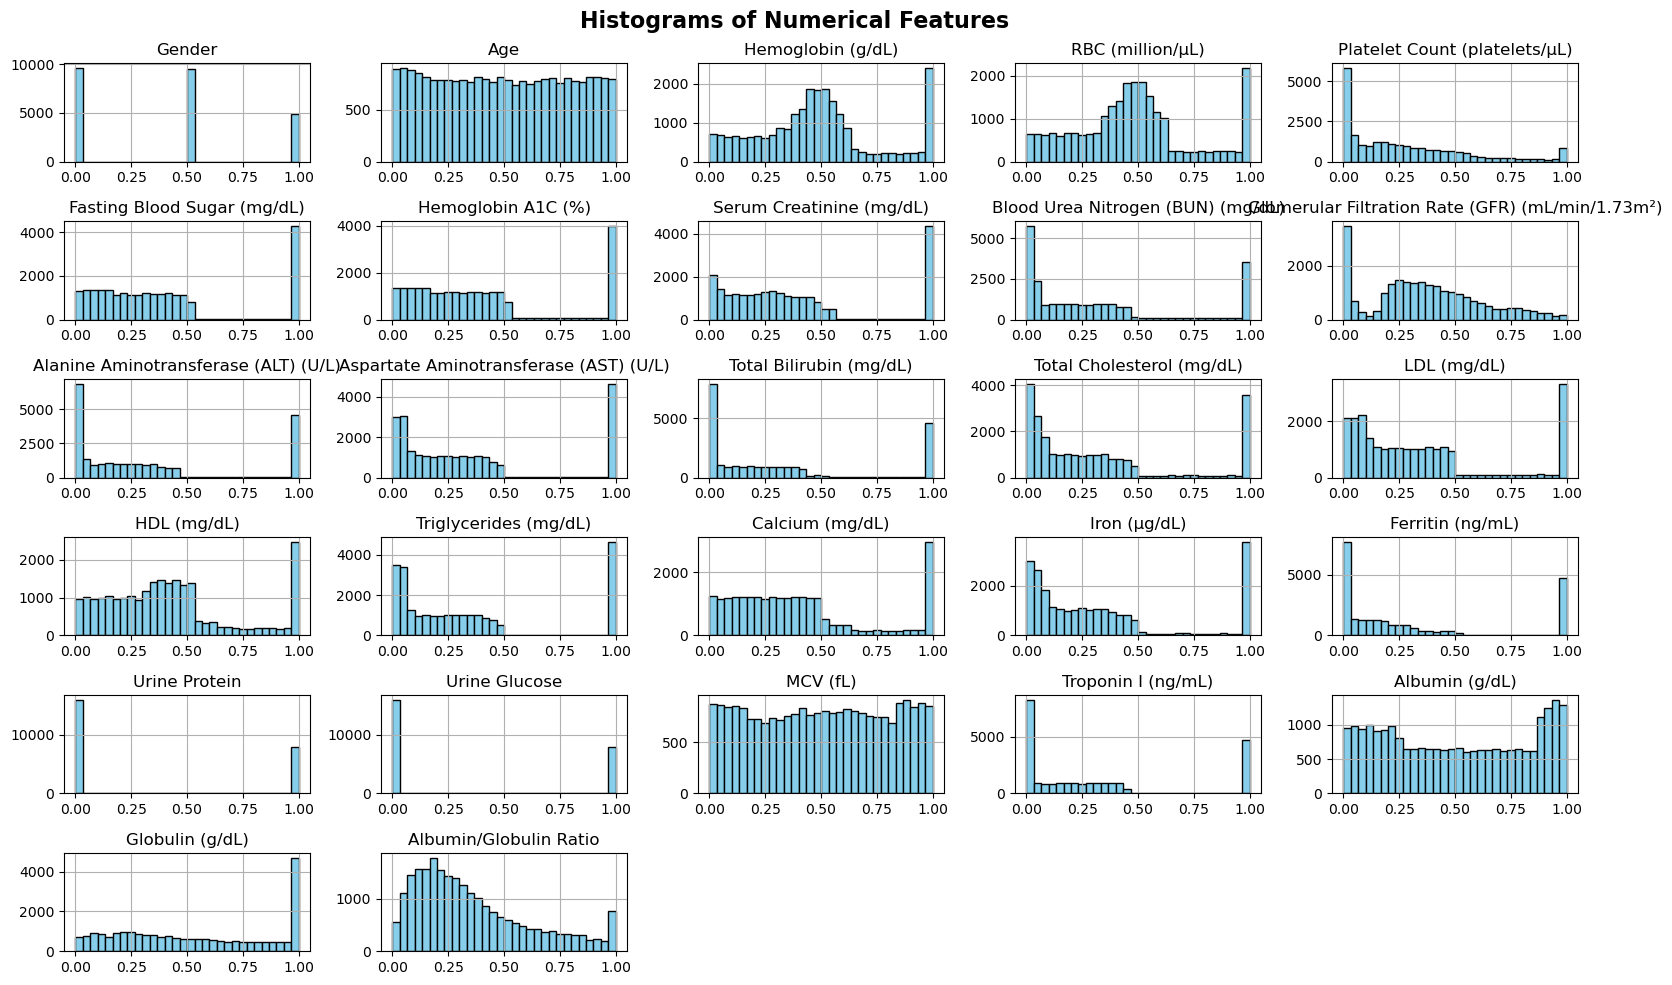

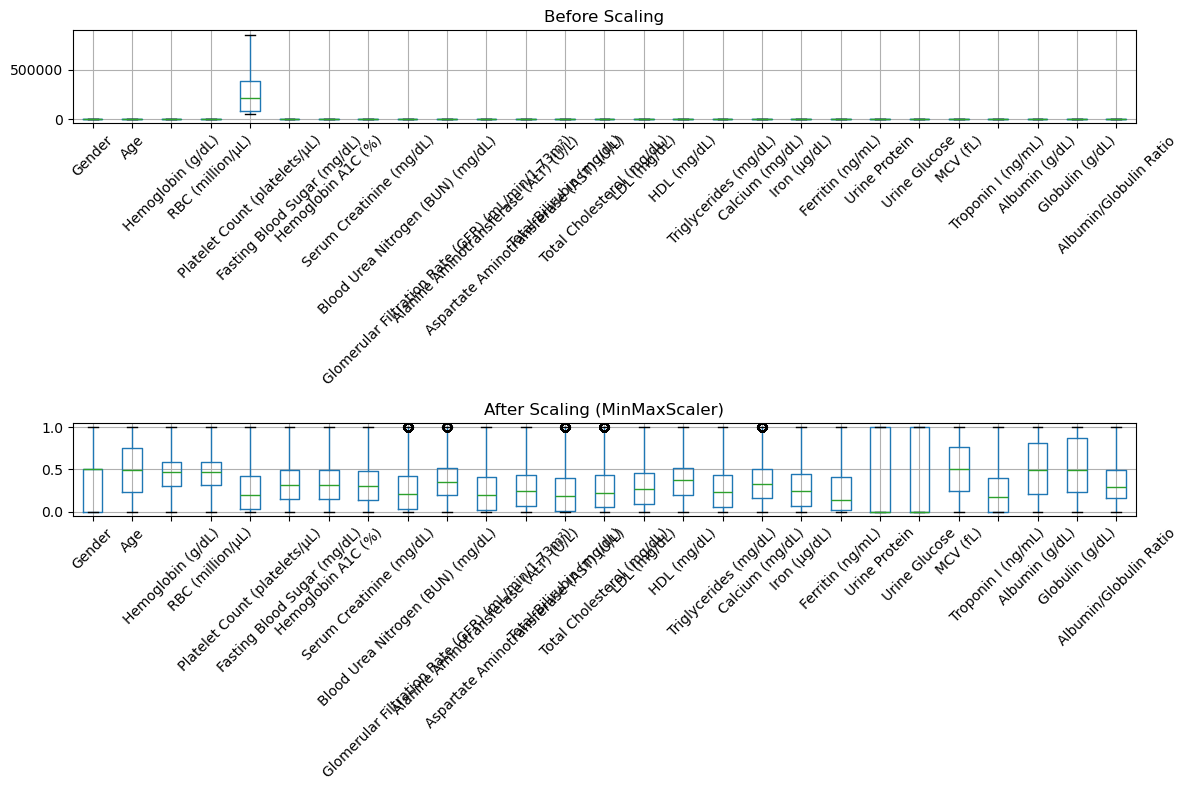

In [16]:
num_df = X_train_scaled.select_dtypes(include=['number'])

plt.figure(figsize=(16, 10))
num_df.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

X_train_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (MinMaxScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [17]:
X_train = X_train_scaled
X_test = X_test_scaled

## **Model Building**

### **XGBoost**

In [18]:
# Define the base XGBoost model
base_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Wrap in MultiOutputClassifier
multi_model = MultiOutputClassifier(base_model)

# Define parameter grid
param_grid = {
    'estimator__n_estimators': [50, 100],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__max_depth': [3, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    multi_model,
    param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\marya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:04:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\marya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:04:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\marya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:04:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\marya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:04:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Best Parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}
Best CV Accuracy: 0.9797083333333334


c:\Users\marya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:04:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### Model Evaluation

In [19]:
# Already trained best model
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train_scaled)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("XGBoost Train Accuracy:", training_accuracy)

y_pred = best_model.predict(X_test_scaled)
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrices
cm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(target_columns):
    print(f"Confusion matrix for {label}:")
    print(cm[i])

XGBoost Train Accuracy: 0.9929583333333334
XGBoost Test Accuracy: 0.9806666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3454
           1       0.99      1.00      0.99      3612
           2       1.00      1.00      1.00      2784
           3       0.99      0.99      0.99      1927
           4       1.00      1.00      1.00      3507

   micro avg       1.00      1.00      1.00     15284
   macro avg       1.00      1.00      1.00     15284
weighted avg       1.00      1.00      1.00     15284
 samples avg       0.97      0.97      0.97     15284

Confusion matrix for Diabetes:
[[2542    4]
 [   6 3448]]
Confusion matrix for Anemia:
[[2343   45]
 [   8 3604]]
Confusion matrix for Kidney Failure:
[[3215    1]
 [   3 2781]]
Confusion matrix for Liver Failure:
[[4061   12]
 [  28 1899]]
Confusion matrix for Ischimic Heart Disease:
[[2488    5]
 [   6 3501]]


c:\Users\marya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Neural Network**

In [20]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(96, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),

    # Output layer for 5 classes (multi-label classification)
    Dense(5, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001  # Minimum change to qualify as improvement
)

# Train Model with larger batch size
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Threshold predictions at 0.5 for multi-label classification
y_pred_train = (model.predict(X_train) > 0.5).astype(int)
y_pred_test = (model.predict(X_test) > 0.5).astype(int)

c:\Users\marya\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7074 - val_loss: 0.4268
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4378 - val_loss: 0.2952
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3587 - val_loss: 0.2523
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3185 - val_loss: 0.2339
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2998 - val_loss: 0.2225
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2857 - val_loss: 0.2158
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2777 - val_loss: 0.2106
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2698 - val_loss: 0.2040
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2597 - val_loss: 0.2011
Epoch 10/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2531 - val_loss: 0.1975
Epoch 11/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2479 - val_loss: 0.1926
Epoch 12/100
300/300 ━━━━━━━━━━━━━━━━━━━━

Evaluation

In [21]:
# Convert predictions and true labels to numpy arrays if they aren't already
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_test_np = y_pred_test.values if hasattr(y_pred_test, 'values') else y_pred_test

# Evaluation metrics for each condition
conditions = ['Diabetes', 'Anemia', 'Kidney Failure', 'Liver Failure', 'Ischemic Heart Disease']

print("\nOverall Accuracy Scores:")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_test_np))

print("\nPer-Condition Classification Reports:")
for i, condition in enumerate(conditions):
    print(f"\n{condition}:")
    print(classification_report(y_test_np[:, i], y_pred_test_np[:, i]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_np[:, i], y_pred_test_np[:, i]))


Overall Accuracy Scores:
Train Accuracy: 0.8685416666666667
Test Accuracy: 0.8416666666666667

Per-Condition Classification Reports:

Diabetes:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2546
           1       1.00      1.00      1.00      3454

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Confusion Matrix:
[[2544    2]
 [  11 3443]]

Anemia:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2388
           1       0.94      0.94      0.94      3612

    accuracy                           0.93      6000
   macro avg       0.92      0.93      0.92      6000
weighted avg       0.93      0.93      0.93      6000

Confusion Matrix:
[[2178  210]
 [ 223 3389]]

Kidney Failure:
              precision    recall  f1-score   support

           0       0.97      0

#### **Models Comparison**

c:\Users\marya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marya\anaconda3\Lib\site-package

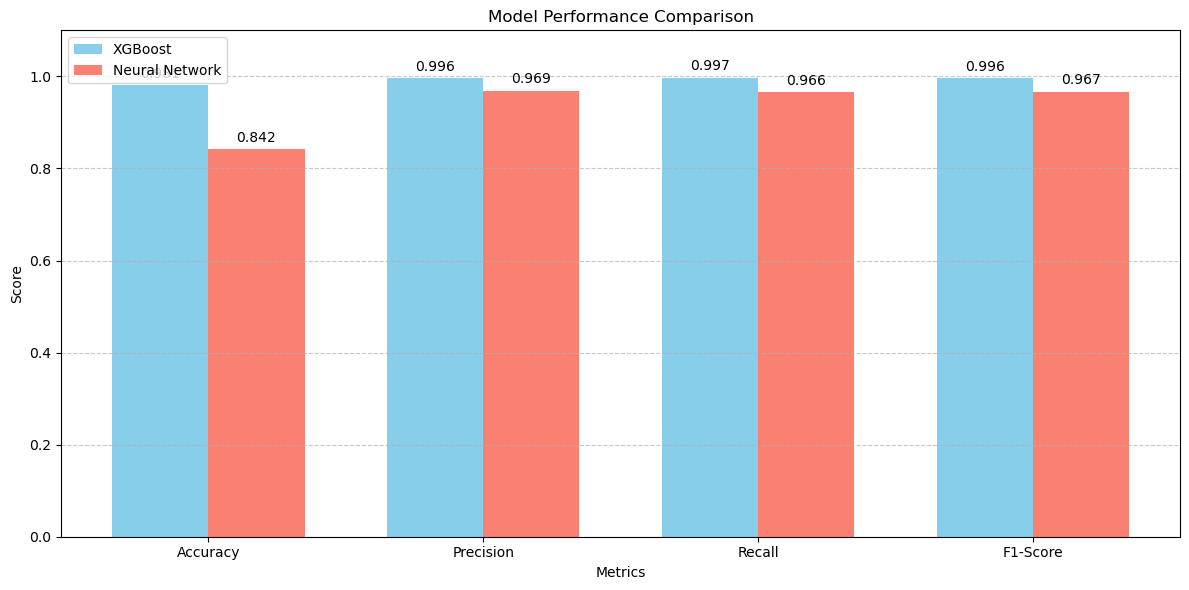

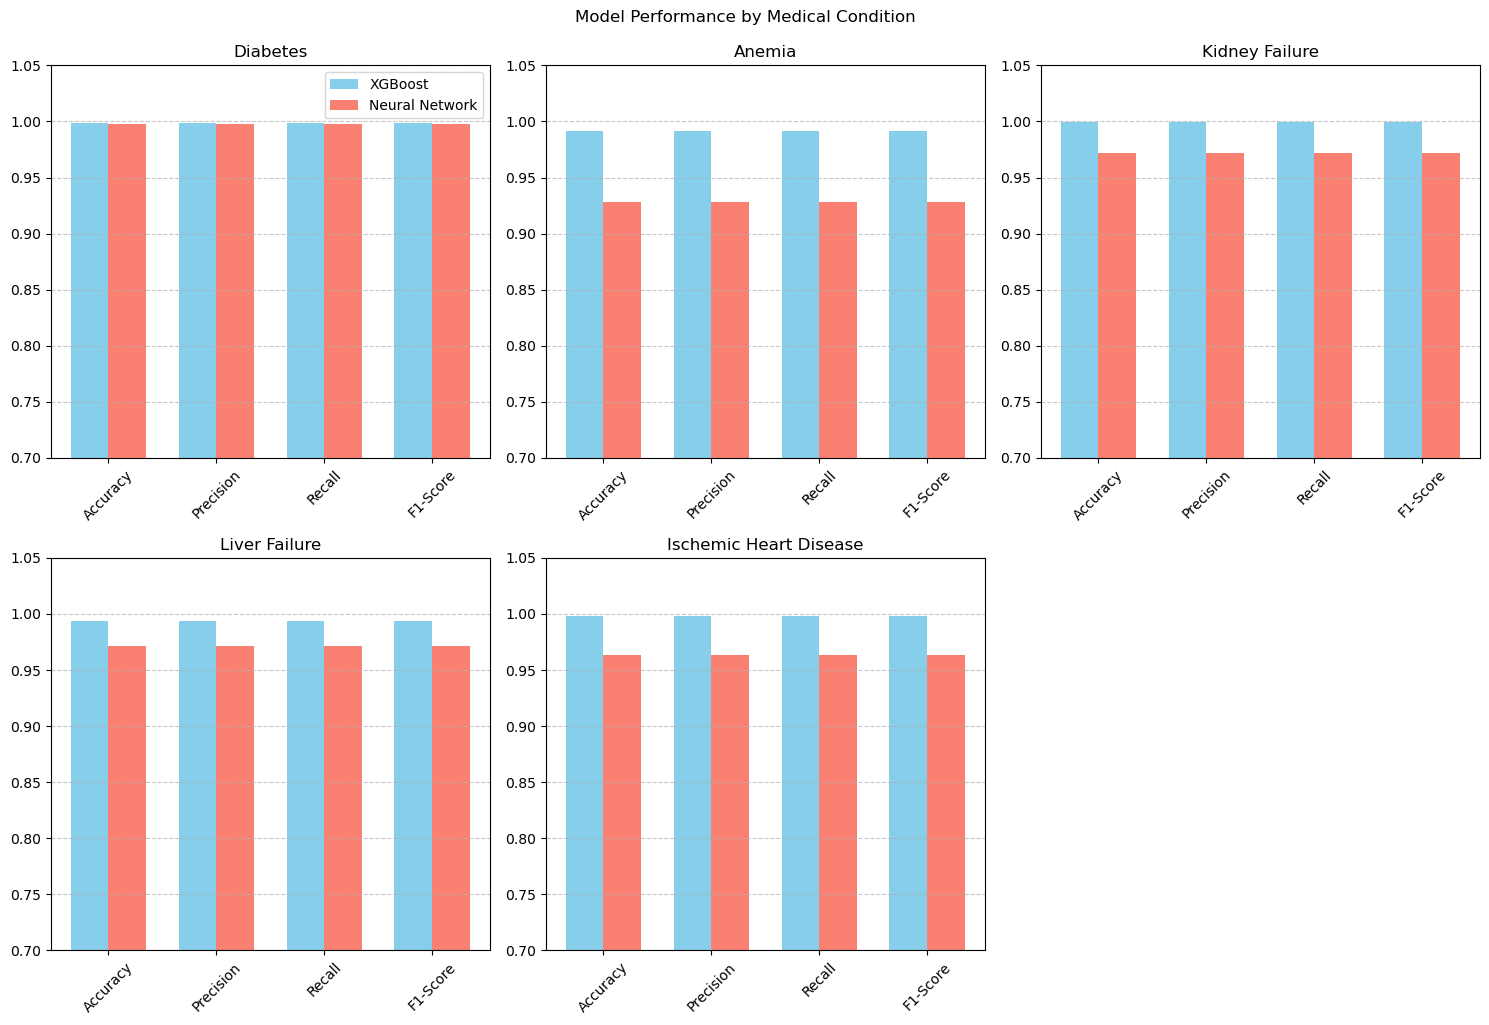

In [22]:
# Prepare the data
model_names = ['XGBoost', 'Neural Network']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Calculate metrics for XGBoost (from your code)
xgboost_report = classification_report(y_test, y_pred, output_dict=True)
xgboost_metrics = [
    accuracy_score(y_test, y_pred),
    xgboost_report['weighted avg']['precision'],
    xgboost_report['weighted avg']['recall'],
    xgboost_report['weighted avg']['f1-score']
]

# Calculate metrics for Neural Network (from your code)
nn_report = classification_report(y_test_np, y_pred_test_np, output_dict=True)
nn_metrics = [
    accuracy_score(y_test_np, y_pred_test_np),
    nn_report['weighted avg']['precision'],
    nn_report['weighted avg']['recall'],
    nn_report['weighted avg']['f1-score']
]

# Create the comparison plot
plt.figure(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, xgboost_metrics, width, label='XGBoost', color='skyblue')
plt.bar(x + width/2, nn_metrics, width, label='Neural Network', color='salmon')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i in range(len(metrics)):
    plt.text(i - width/2, xgboost_metrics[i] + 0.01, f'{xgboost_metrics[i]:.3f}',
             ha='center', va='bottom')
    plt.text(i + width/2, nn_metrics[i] + 0.01, f'{nn_metrics[i]:.3f}',
             ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Condition-specific comparison
conditions = ['Diabetes', 'Anemia', 'Kidney Failure', 'Liver Failure', 'Ischemic Heart Disease']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

plt.figure(figsize=(15, 10))
for i, condition in enumerate(conditions):
    # Get XGBoost metrics for this condition
    xg_cond_report = classification_report(y_test.iloc[:, i], y_pred[:, i], output_dict=True)
    xg_cond_metrics = [
        accuracy_score(y_test.iloc[:, i], y_pred[:, i]),
        xg_cond_report['weighted avg']['precision'],
        xg_cond_report['weighted avg']['recall'],
        xg_cond_report['weighted avg']['f1-score']
    ]

    # Get Neural Network metrics for this condition
    nn_cond_report = classification_report(y_test_np[:, i], y_pred_test_np[:, i], output_dict=True)
    nn_cond_metrics = [
        accuracy_score(y_test_np[:, i], y_pred_test_np[:, i]),
        nn_cond_report['weighted avg']['precision'],
        nn_cond_report['weighted avg']['recall'],
        nn_cond_report['weighted avg']['f1-score']
    ]

    plt.subplot(2, 3, i+1)
    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, xg_cond_metrics, width, label='XGBoost', color='skyblue')
    plt.bar(x + width/2, nn_cond_metrics, width, label='Neural Network', color='salmon')

    plt.title(condition)
    plt.xticks(x, metrics, rotation=45)
    plt.ylim(0.7, 1.05)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    if i == 0:
        plt.legend()

plt.tight_layout()
plt.suptitle('Model Performance by Medical Condition', y=1.02)
plt.show()

# **---------------- Progression ----------------**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

logger.info("All libraries for Progression imported successfully.")

2025-05-08 15:09:19,847 - INFO - All libraries for Progression imported successfully.


## **Anemia_progression**

### Data Cleaning

In [ ]:
df = pd.read_csv("/content/anemia_progression_dataset.csv")

# Encode gender
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Cap outliers (IQR method)
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)

# Save cleaned dataset
output_file = "cleaned_tests_Anemia.csv"
df.to_csv(output_file, index=False)
print(f"Cleaned data saved to {output_file}")
df.head(10)

logger.info("Data is Cleaned")


2025-05-08 15:56:37,914 - INFO - Data is Cleaned


Cleaned data saved to cleaned_tests_Anemia.csv


### Correlation Heatmaps Before Splitting

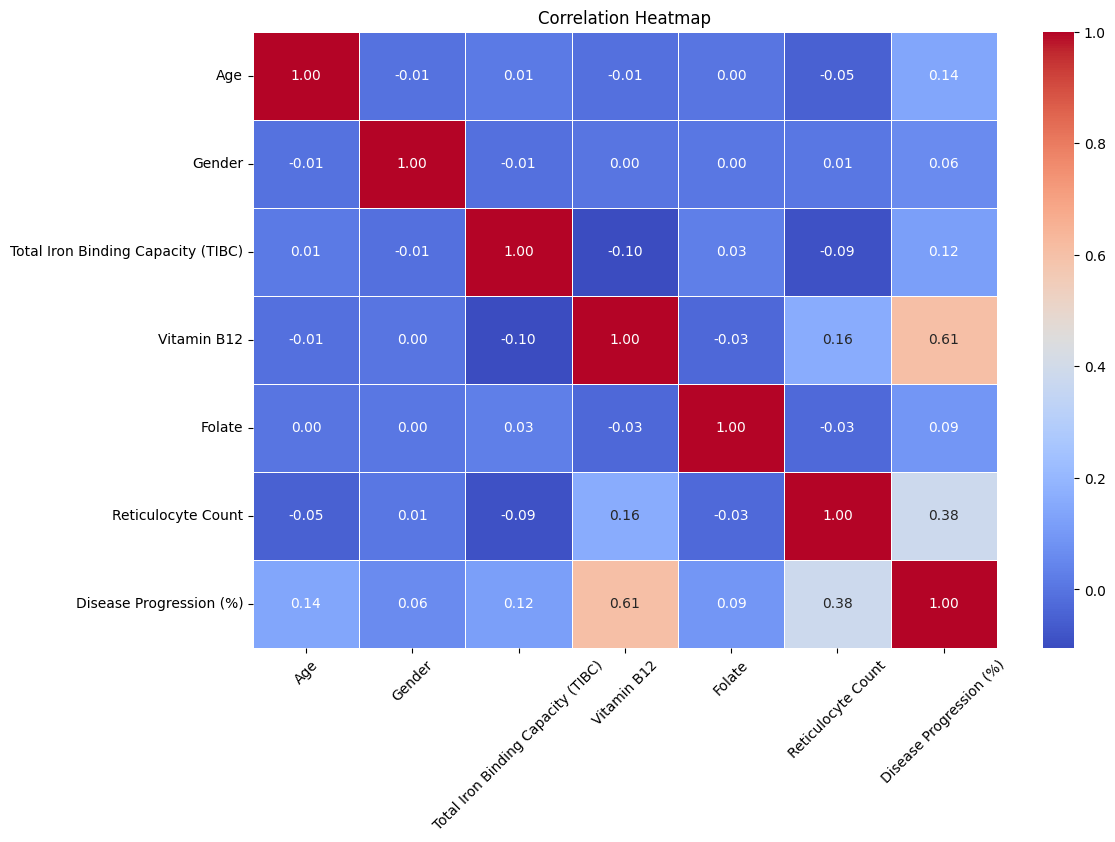

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

### Train test Split

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log after splitting
logger.info("Data has been split into training and testing sets.")

2025-05-08 15:56:41,453 - INFO - Data has been split into training and testing sets.


### Min-Max Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

logger.info("Features are Scaled")

2025-05-08 15:56:43,478 - INFO - Features are Scaled


### Data visualization

<Figure size 1600x1000 with 0 Axes>

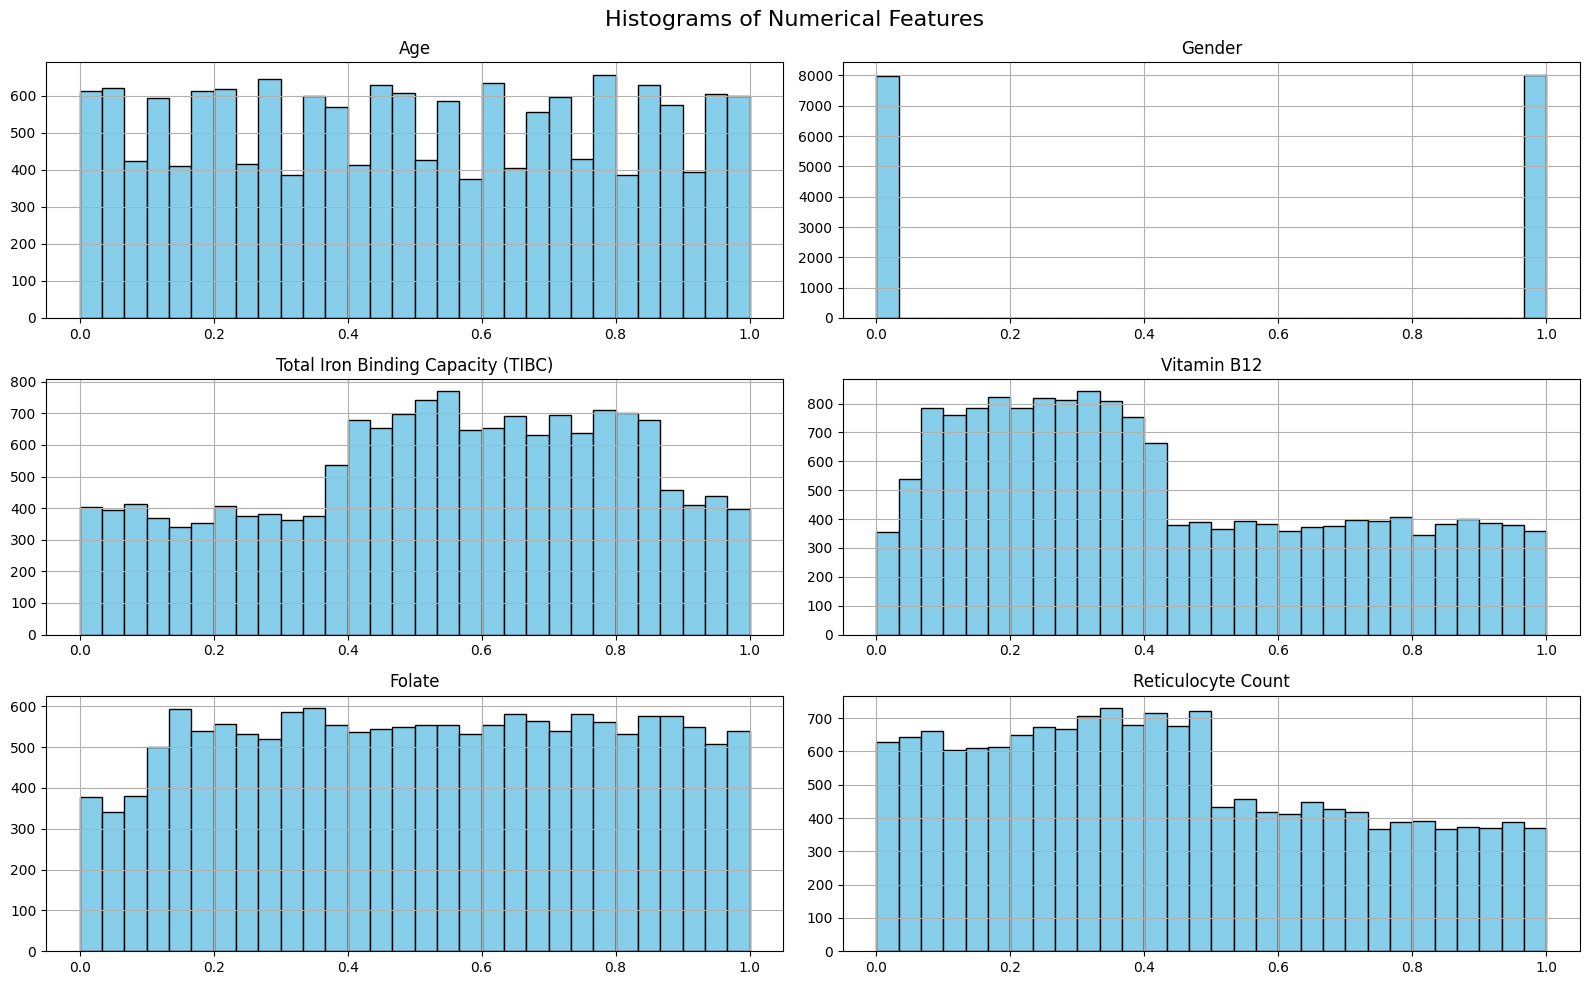

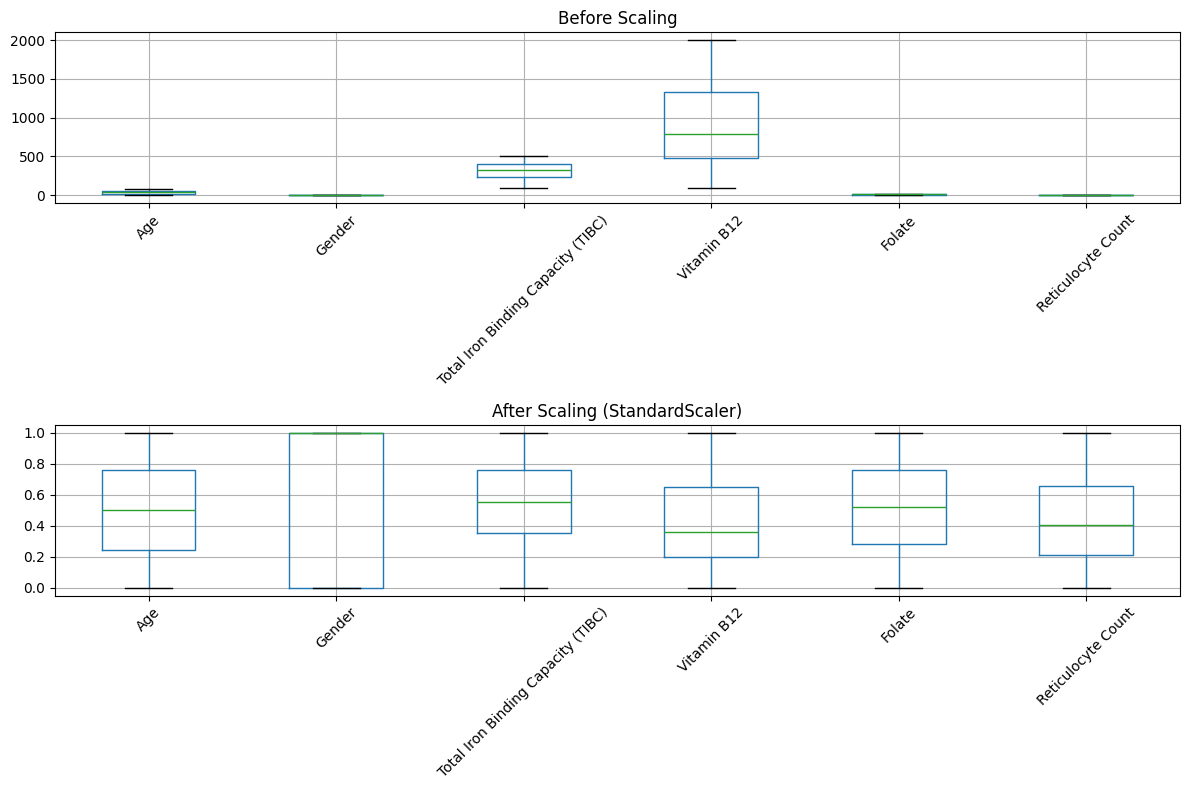

In [ ]:
plt.figure(figsize=(16, 10))
X_train_scaled.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Plot before and after scaling
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Before scaling
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

# After scaling
X_train_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

### **Model Building**

In [ ]:
# Store models and results to compare later
models = {}
results = {}

1. **Linear Regression with ridge regularization**

In [ ]:
# 1. Ridge Regression
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_pred_ridge = ridge_grid.predict(X_test)

models['Ridge'] = ridge_grid.best_estimator_
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge),
    'Params': ridge_grid.best_params_
}
logger.info(f"Ridge Regression evaluation complete. RMSE: {results['Ridge']['RMSE']:.4f}, R2: {results['Ridge']['R2']:.4f}, Best Params: {results['Ridge']['Params']}")


2025-05-08 15:56:51,055 - INFO - Ridge Regression evaluation complete. RMSE: 19.9749, R2: 0.5349, Best Params: {'alpha': 0.1}


2. **Neural Network**

In [ ]:
# --- Define NN Architecture ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

# --- Compile the Model ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse'])

# --- Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Extract Hyperparameters ---
def get_model_params(model):
    params = {}

    # Optimizer parameters
    if hasattr(model.optimizer, 'learning_rate'):
        params['learning_rate'] = float(model.optimizer.learning_rate.numpy())

    # Layer-specific parameters
    for layer in model.layers:
        if isinstance(layer, Dense):
            params[f'dense_units_{layer.name}'] = layer.units
            params[f'activation_{layer.name}'] = layer.activation.__name__
        elif isinstance(layer, Dropout):
            params[f'dropout_rate_{layer.name}'] = layer.rate
        elif isinstance(layer, BatchNormalization):
            params[f'batchnorm_{layer.name}'] = True

        return params

# --- Predict & Evaluate ---
y_pred_nn = model.predict(X_test).flatten()

# Store results
models['Neural Network'] = model
results['Neural Network'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'R2': r2_score(y_test, y_pred_nn),
    'Params': get_model_params(model)
}


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1900.0963 - mse: 1900.0963 - val_loss: 1203.1809 - val_mse: 1203.1809
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 907.9626 - mse: 907.9626 - val_loss: 394.9155 - val_mse: 394.9155
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 387.5021 - mse: 387.5021 - val_loss: 239.4400 - val_mse: 239.4400
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 328.5531 - mse: 328.5531 - val_loss: 227.8066 - val_mse: 227.8066
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 308.3372 - mse: 308.3372 - val_loss: 228.7511 - val_mse: 228.7511
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 311.4362 - mse: 311.4362 - val_loss: 226.4407 - val_mse: 226.4407
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 302.8342 - mse: 302.8342 - val_loss: 213.6899 - val_mse: 213.6899
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 285.4219 - mse: 285.4219 - val_loss: 215.3128 - val_mse: 215.3128

3. **XGBoost Regressor**

In [ ]:
# 3. XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

models['XGBoost'] = grid_search.best_params_
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb),
    'Params': grid_search.best_params_
}


Fitting 3 folds for each of 72 candidates, totalling 216 fits


**Models Evaluation and comparison**

In [ ]:
print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE        = {metrics['RMSE']:.2f}")
    print(f"  R²          = {metrics['R2']:.4f}")
    print(f"  Params = {metrics['Params']}")

Model Comparison:
Ridge:
  RMSE        = 19.97
  R²          = 0.5349
  Params = {'alpha': 0.1}
Neural Network:
  RMSE        = 13.63
  R²          = 0.7833
  Params = {'learning_rate': 0.0010000000474974513, 'dense_units_dense_5': 64, 'activation_dense_5': 'relu'}
XGBoost:
  RMSE        = 11.79
  R²          = 0.8378
  Params = {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


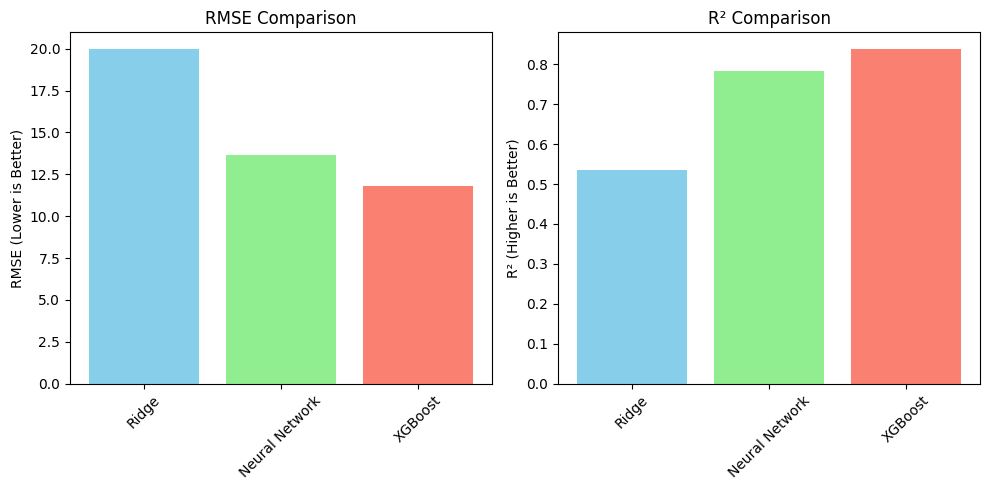

In [ ]:
# Extract metrics
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
r2_values = [results[model]['R2'] for model in model_names]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('R² Comparison')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## **Diabetes_progression**

### Data Cleaning

In [ ]:
# Load dataset
df = pd.read_csv("/content/diabetes_progression_dataset_with_classification.csv")
print(df.info())
print(df.head())

# Label encoding
label_maps = {
    'Gender': {'Male': 0, 'Female': 1},
    'Diabetes Type': {'No Diabetes': 0, 'Type 1': 1, 'Type 2': 2}
}
for col, mapping in label_maps.items():
    df[col] = df[col].map(mapping)

# Remove nulls
df.fillna(df.median(numeric_only=True), inplace=True)

# Remove duplicates
duplicates = df.duplicated().sum()
print(f"Found {duplicates} duplicate rows.")
df.drop_duplicates(inplace=True)

# Cap outliers
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)

# Save cleaned data
df.to_csv("cleaned_diabetes_dataset.csv", index=False)
print("Cleaned data saved.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 20000 non-null  int64  
 1   Gender                              20000 non-null  object 
 2   Oral Glucose Tolerance Test (OGTT)  20000 non-null  float64
 3   C-Peptide                           20000 non-null  float64
 4   Microalbuminuria (Urine Albumin)    20000 non-null  float64
 5   Disease Progression (%)             20000 non-null  float64
 6   Diabetes Type                       20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.1+ MB
None
   Age    Gender  Oral Glucose Tolerance Test (OGTT)  C-Peptide  \
0   13  Children                          229.801337   0.353615   
1   41      Male                          103.728608   1.285470   
2   39      Male                       

### Correlation Heatmaps before splitting

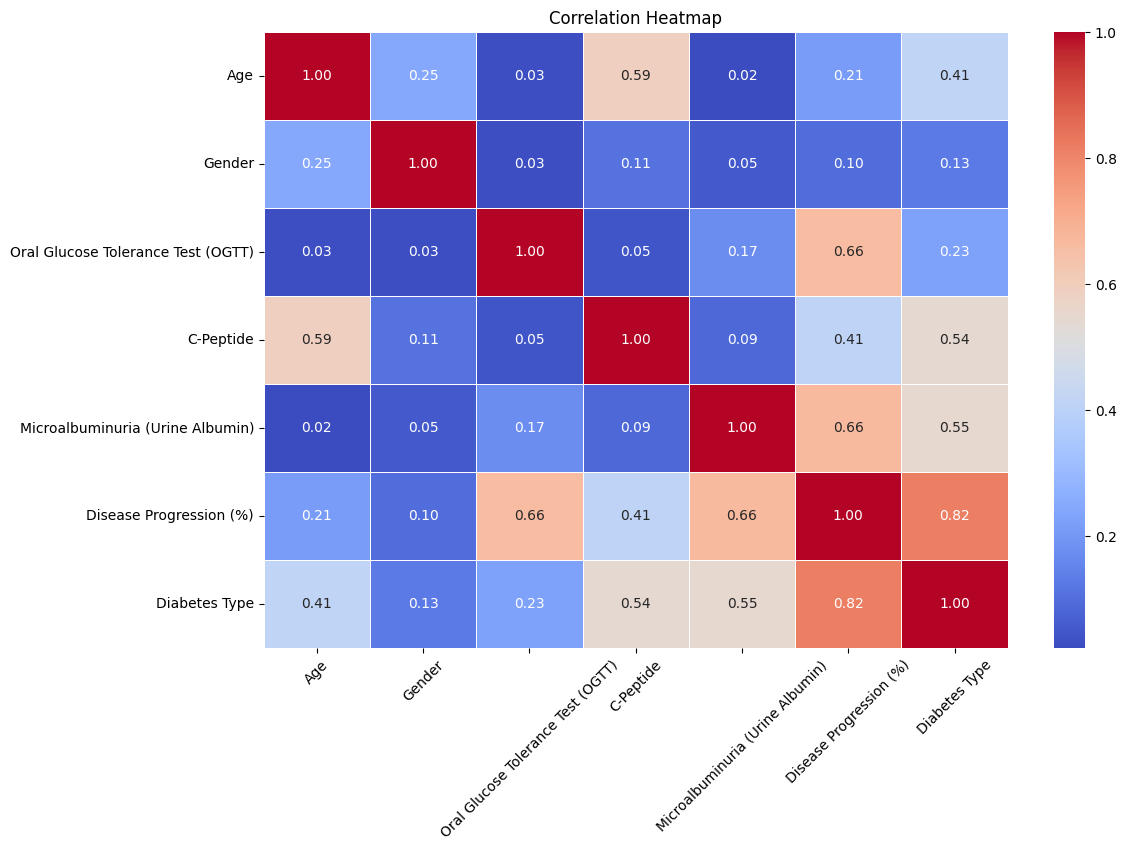

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

### Train-Test Split

In [ ]:
# Separate features and targets
X = df.drop(['Disease Progression (%)', 'Diabetes Type'], axis=1)
y_reg = df['Disease Progression (%)']
y_cls = df['Diabetes Type']

# Split
X_train, X_test, y_train_reg, y_test_reg, y_train_cls, y_test_cls = train_test_split(X, y_reg, y_cls, test_size=0.2, random_state=42)

logger.info("Data has been split into training and testing sets.")

2025-05-08 15:57:21,324 - INFO - Data has been split into training and testing sets.


### Min-Max Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logger.info("Features are Scaled")

2025-05-08 15:57:29,887 - INFO - Features are Scaled


### Data visualization

<Figure size 1600x1000 with 0 Axes>

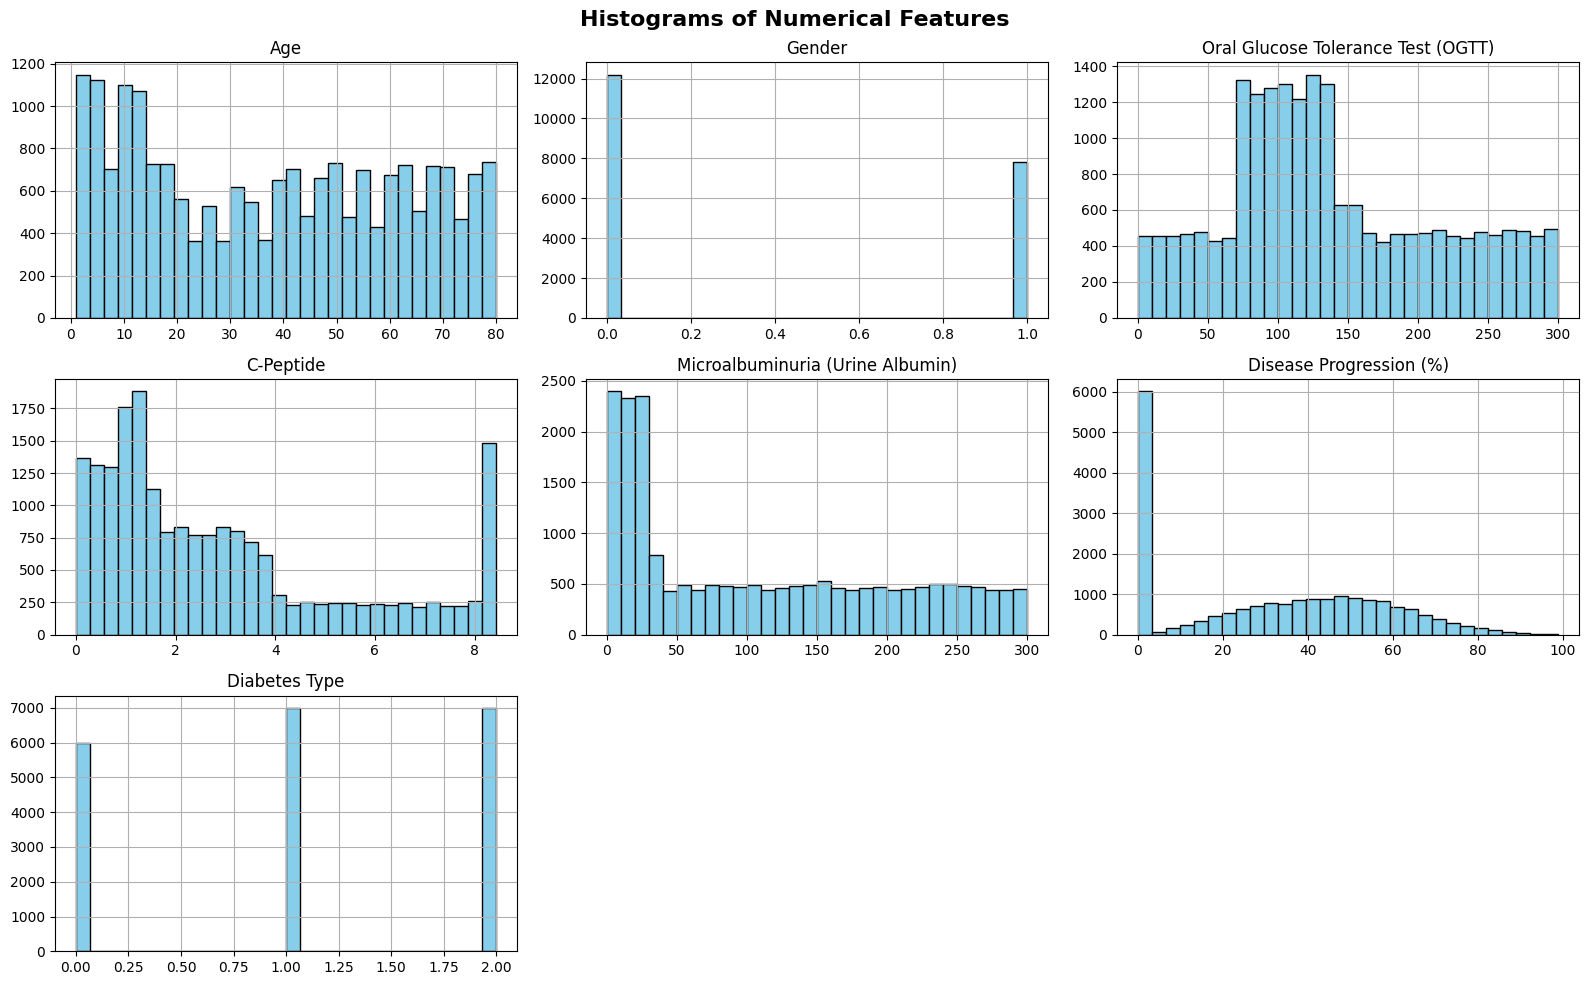

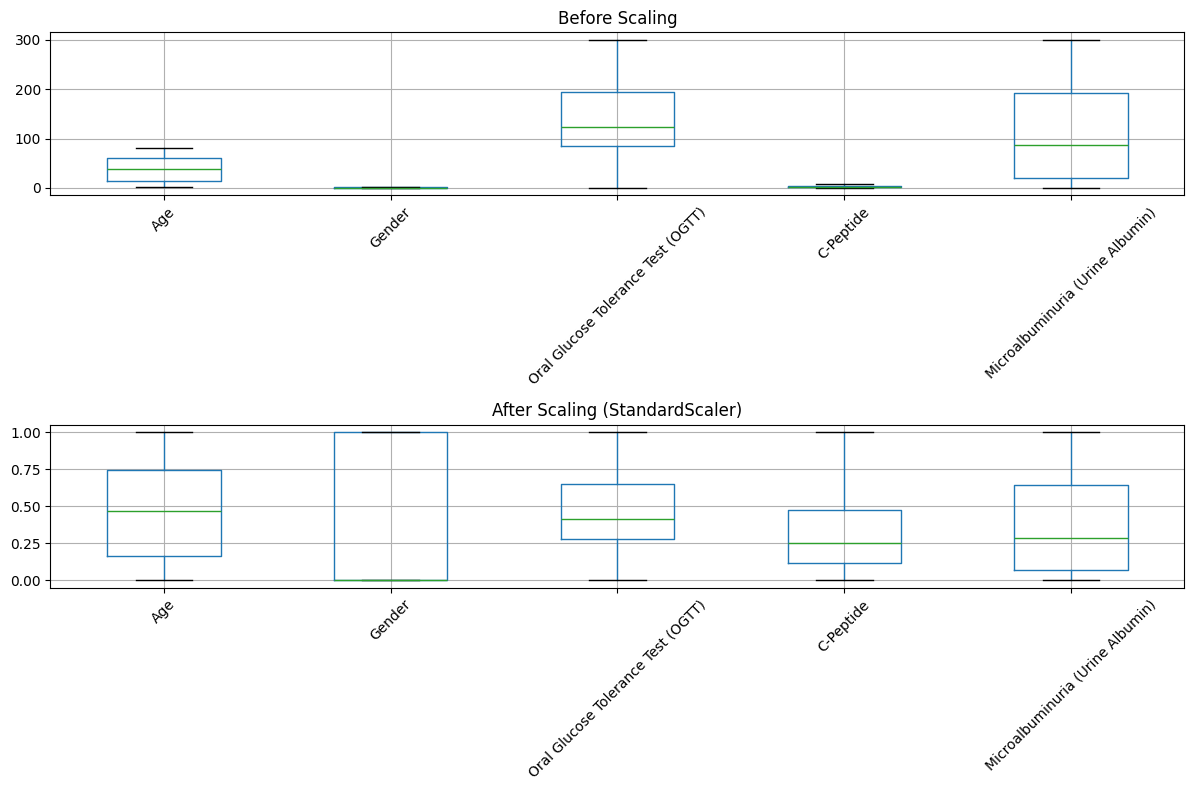

In [ ]:
# Histogram
plt.figure(figsize=(16, 10))
df.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot before and after scaling
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Before scaling
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

# After scaling
scaledframe = pd.DataFrame(X_train_scaled, columns=X_train.columns) # Converting to df for visualization
scaledframe.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

### Model training and Evaluation

In [ ]:
# Store models and results to compare later
models = {}
results = {}

1. **Linear Regression with Ridge Regularization**

In [ ]:
# 1. Ridge Regression
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train_reg)
y_pred_ridge = ridge_grid.predict(X_test)

models['Ridge'] = ridge_grid.best_estimator_
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge)),
    'R2': r2_score(y_test_reg, y_pred_ridge),
    'Params': ridge_grid.best_params_
}

logger.info(f"Ridge Regression evaluation complete. RMSE: {results['Ridge']['RMSE']:.4f}, R2: {results['Ridge']['R2']:.4f}, Best Params: {results['Ridge']['Params']}")

2025-05-08 15:57:50,256 - INFO - Ridge Regression evaluation complete. RMSE: 9.4655, R2: 0.8619, Best Params: {'alpha': 0.01}


2. **Neural Network**

In [ ]:
# --- Define NN Architecture ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

# --- Compile the Model ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse'])

# --- Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train_reg,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Extract Hyperparameters ---
def get_model_params(model):
    params = {}

    # Optimizer parameters
    if hasattr(model.optimizer, 'learning_rate'):
        params['learning_rate'] = float(model.optimizer.learning_rate.numpy())

    # Layer-specific parameters
    for layer in model.layers:
        if isinstance(layer, Dense):
            params[f'dense_units_{layer.name}'] = layer.units
            params[f'activation_{layer.name}'] = layer.activation.__name__
        elif isinstance(layer, Dropout):
            params[f'dropout_rate_{layer.name}'] = layer.rate
        elif isinstance(layer, BatchNormalization):
            params[f'batchnorm_{layer.name}'] = True

        return params

# --- Predict & Evaluate ---
y_pred_nn = model.predict(X_test).flatten()

# Store results
models['Neural Network'] = model
results['Neural Network'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_nn)),
    'R2': r2_score(y_test_reg, y_pred_nn),
    'Params': get_model_params(model)
}

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1271.6587 - mse: 1271.6587 - val_loss: 488.4923 - val_mse: 488.4923
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 421.9931 - mse: 421.9931 - val_loss: 81.5976 - val_mse: 81.5976
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 103.9572 - mse: 103.9572 - val_loss: 22.6336 - val_mse: 22.6336
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 66.0870 - mse: 66.0870 - val_loss: 17.7919 - val_mse: 17.7919
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 60.3371 - mse: 60.3371 - val_loss: 17.6738 - val_mse: 17.6738
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60.6915 - mse: 60.6915 - val_loss: 14.6839 - val_mse: 14.6839
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 58.7122 - mse: 58.7122 - val_loss: 14.9712 - val_mse: 14.9712
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.5278 - mse: 58.5278 - val_loss: 14.8354 - val_mse: 14.8354
Epoch 9/50
400/400 ━━━━━━

3. **XGBoost Regressor**

In [ ]:
# 3. XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train_reg)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

models['XGBoost'] = grid_search.best_params_
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb)),
    'R2': r2_score(y_test_reg, y_pred_xgb),
    'Params': grid_search.best_params_
}

Fitting 3 folds for each of 72 candidates, totalling 216 fits


Models Comparison

Model Comparison:
Ridge:
  RMSE        = 9.47
  R²          = 0.8619
  Params = {'alpha': 0.01}
Neural Network:
  RMSE        = 3.50
  R²          = 0.9811
  Params = {'learning_rate': 0.0010000000474974513, 'dense_units_dense_8': 64, 'activation_dense_8': 'relu'}
XGBoost:
  RMSE        = 2.31
  R²          = 0.9917
  Params = {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


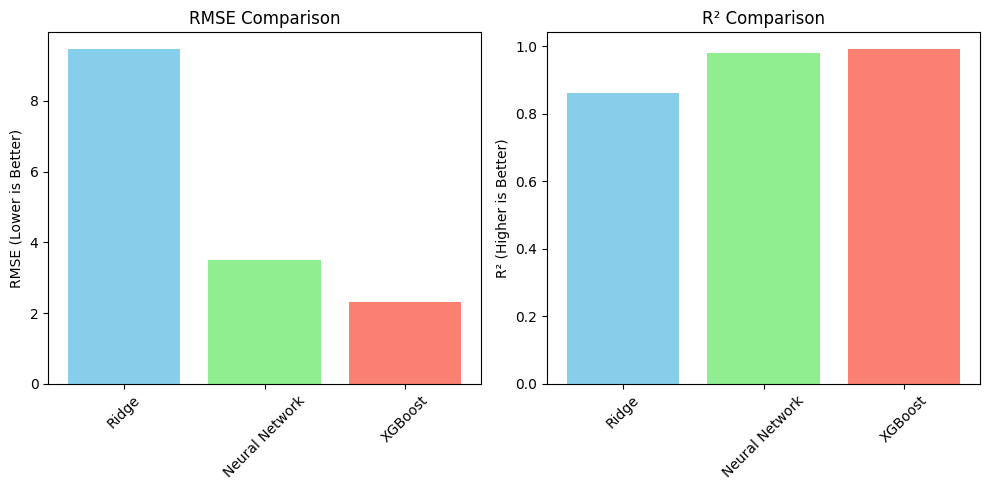

In [ ]:
print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE        = {metrics['RMSE']:.2f}")
    print(f"  R²          = {metrics['R2']:.4f}")
    print(f"  Params = {metrics['Params']}")

# Extract metrics
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
r2_values = [results[model]['R2'] for model in model_names]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('R² Comparison')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#### **XGBoost Classification**

Best Classification Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost Classification Train Accuracy: 0.99325
XGBoost Classification Test Accuracy: 0.99325
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1224
           1       1.00      0.99      1.00      1406
           2       1.00      0.99      0.99      1370

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



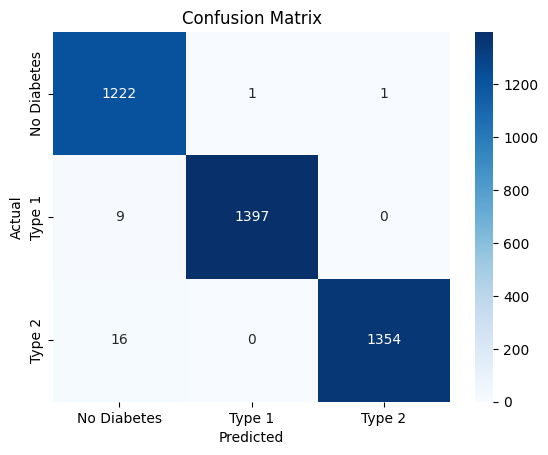

In [ ]:
cls_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
xgb_cls = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
grid_cls = GridSearchCV(xgb_cls, cls_params, cv=3, scoring='accuracy')
grid_cls.fit(X_train_scaled, y_train_cls)

print("Best Classification Params:", grid_cls.best_params_)

y_train_pred_cls = grid_cls.predict(X_train_scaled)
y_pred_cls = grid_cls.predict(X_test_scaled)

train_acc = accuracy_score(y_train_cls, y_train_pred_cls)
print("XGBoost Classification Train Accuracy:", train_acc)
acc = accuracy_score(y_test_cls, y_pred_cls)
print("XGBoost Classification Test Accuracy:", acc)
print("Classification Report:\n", classification_report(y_test_cls, y_pred_cls))

# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Type 1', 'Type 2'],
            yticklabels=['No Diabetes', 'Type 1', 'Type 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## **Kidney_disease Progression**

### Data Cleaning

In [ ]:
df = pd.read_csv("/content/kidney_disease_progression_dataset.csv")

print(df.info())
print(df.head())

#label encoding
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

# removing nulls
df.fillna(df.median(), inplace=True)

# removing duplicates
duplicate_count = df.duplicated().sum()
print(f" Found {duplicate_count} duplicate rows.")
df.drop_duplicates(inplace=True)

# removing outliers
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


output_file = "cleaned_tests(Kidney).csv"
df.to_csv(output_file, index=False)

print(f" Cleaned data successfully {output_file}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               20000 non-null  int64  
 1   Gender                            20000 non-null  object 
 2   24-hour Urine Protein             20000 non-null  float64
 3   Serum Uric Acid                   20000 non-null  float64
 4   Serum Creatinine                  20000 non-null  float64
 5   Glomerular Filtration Rate (GFR)  20000 non-null  float64
 6   Blood Urea Nitrogen (BUN)         20000 non-null  float64
 7   Disease Progression (%)           20000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.2+ MB
None
   Age  Gender  24-hour Urine Protein  Serum Uric Acid  Serum Creatinine  \
0   35  Female             510.974002        11.696598          9.384053   
1   24  Female              92.690168      

### Heatmaps for ther whole dataset before splitting

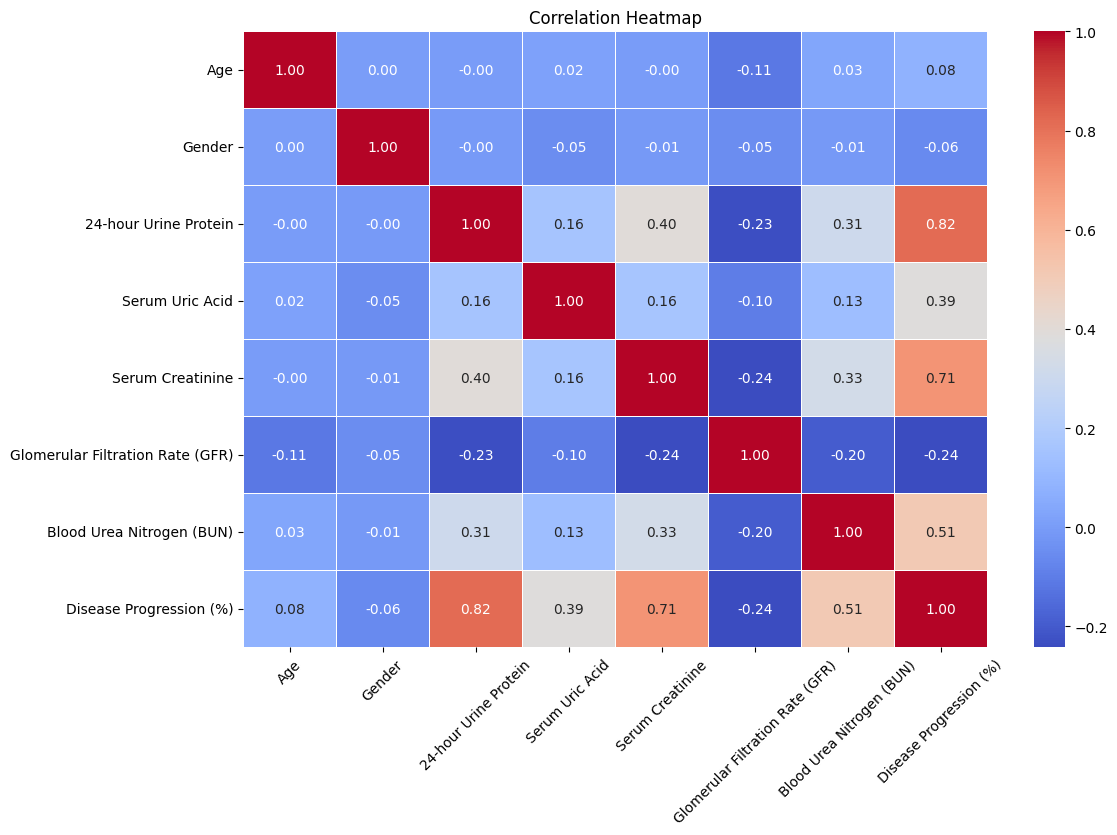

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

### Train-Test Split

In [ ]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

logger.info("Data has been split into training and testing sets.")


2025-05-08 15:58:56,910 - INFO - Data has been split into training and testing sets.



### Min_Max Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

logger.info("Features are Scaled")

2025-05-08 15:59:02,869 - INFO - Features are Scaled


### Data visualization

<Figure size 1600x1000 with 0 Axes>

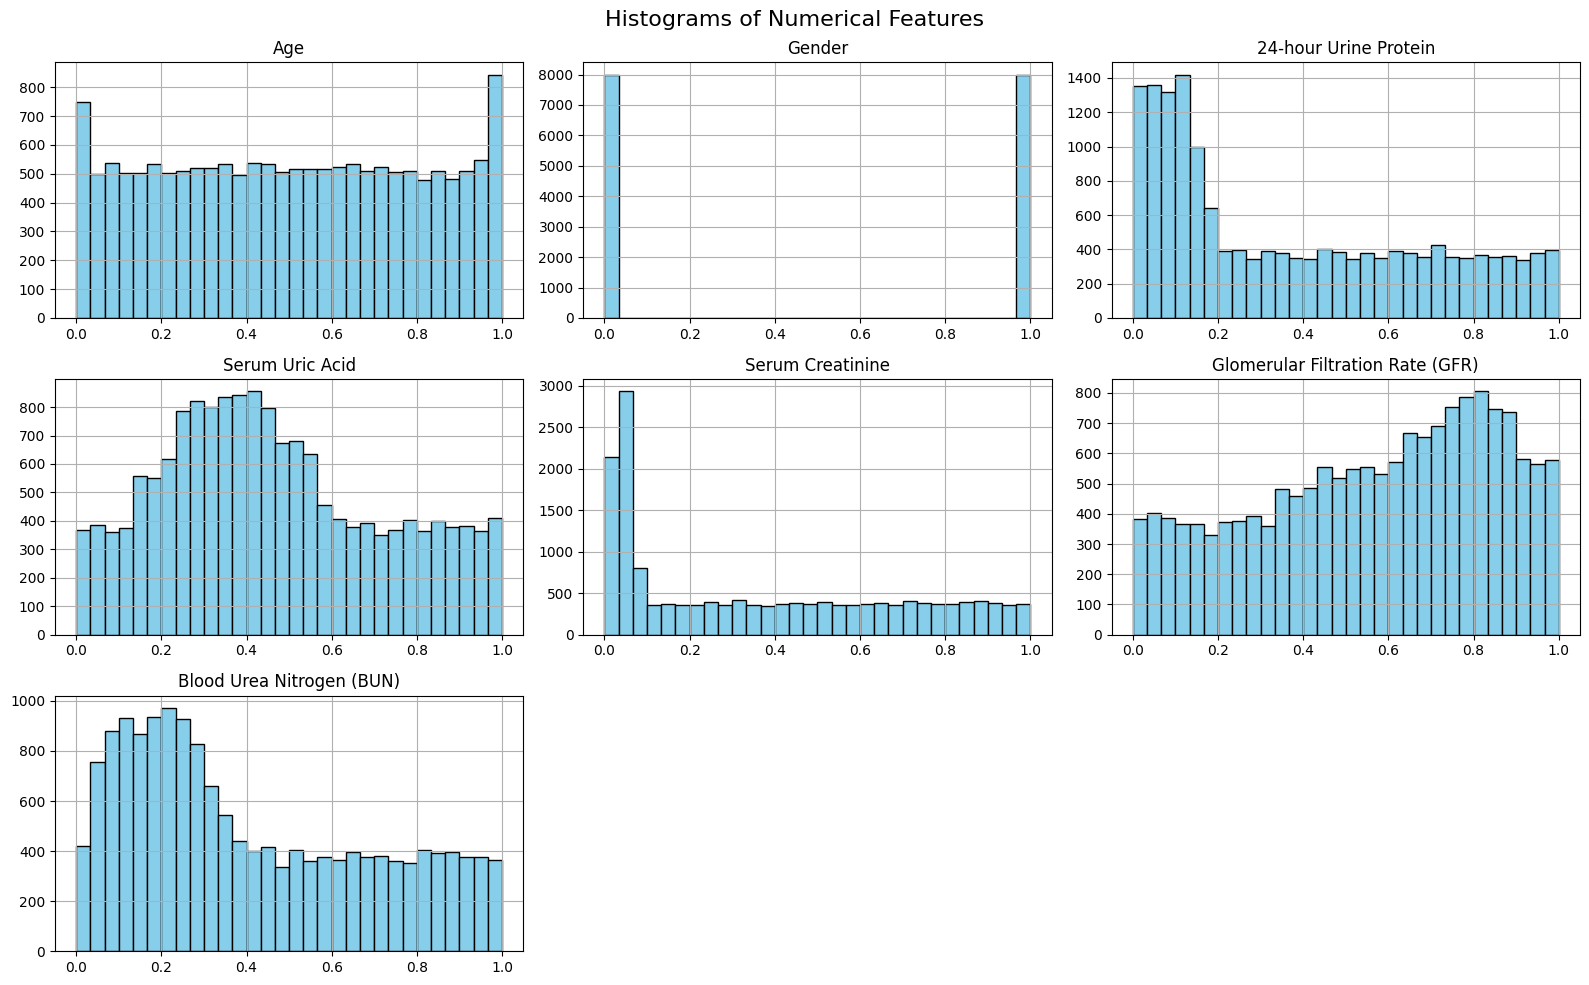

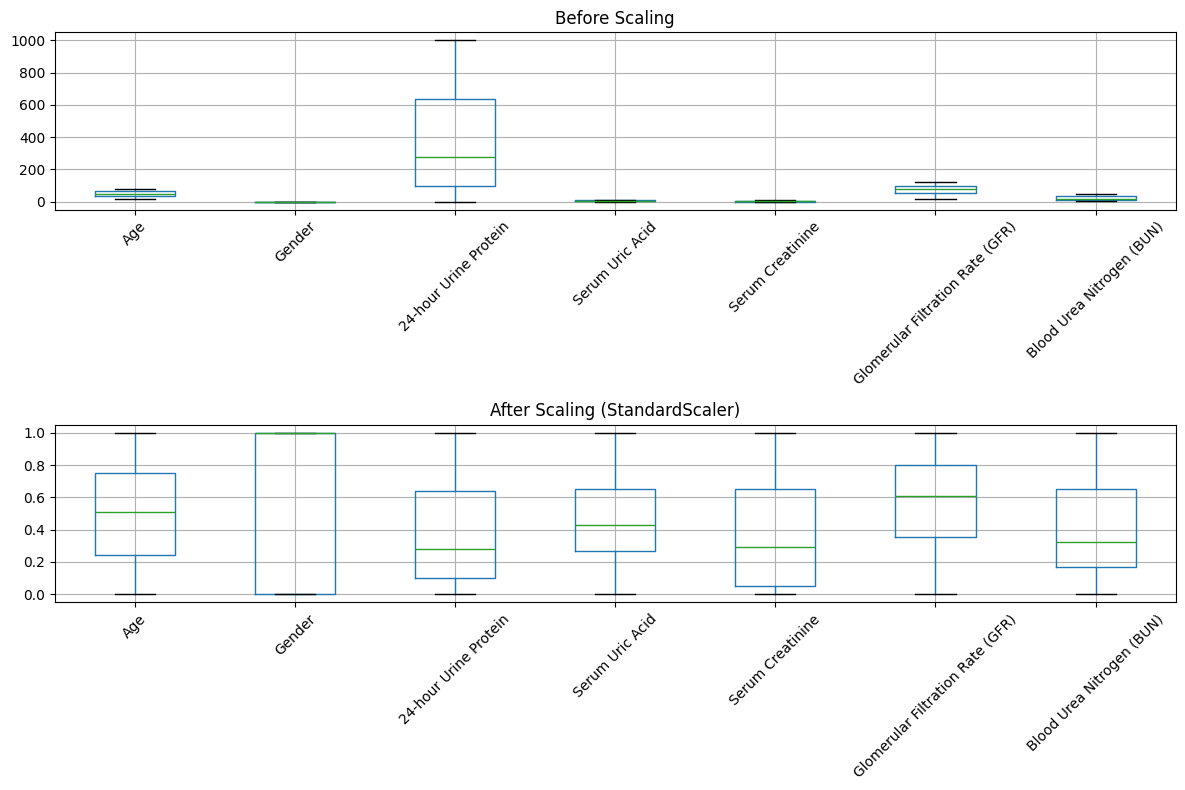

In [ ]:
plt.figure(figsize=(16, 10))
X_train_scaled.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Plot before and after scaling
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Before scaling
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

# After scaling
X_train_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Model Training and Evaluation

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

In [ ]:
# Store models and results to compare later
models = {}
results = {}

1. **Linear Regression with Ridge regularization**

In [ ]:
# 1. Ridge Regression
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_pred_ridge = ridge_grid.predict(X_test)

models['Ridge'] = ridge_grid.best_estimator_
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge),
    'Params': ridge_grid.best_params_
}

logger.info(f"Ridge Regression evaluation complete. RMSE: {results['Ridge']['RMSE']:.4f}, R2: {results['Ridge']['R2']:.4f}, Best Params: {results['Ridge']['Params']}")

2025-05-08 16:03:15,941 - INFO - Ridge Regression evaluation complete. RMSE: 7.6548, R2: 0.9321, Best Params: {'alpha': 0.01}


2. **Neural Network**

In [ ]:
# --- Define NN Architecture ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

# --- Compile the Model ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse'])

# --- Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Extract Hyperparameters ---
def get_model_params(model):
    params = {}

    # Optimizer parameters
    if hasattr(model.optimizer, 'learning_rate'):
        params['learning_rate'] = float(model.optimizer.learning_rate.numpy())

    # Layer-specific parameters
    for layer in model.layers:
        if isinstance(layer, Dense):
            params[f'dense_units_{layer.name}'] = layer.units
            params[f'activation_{layer.name}'] = layer.activation.__name__
        elif isinstance(layer, Dropout):
            params[f'dropout_rate_{layer.name}'] = layer.rate
        elif isinstance(layer, BatchNormalization):
            params[f'batchnorm_{layer.name}'] = True

        return params

# --- Predict & Evaluate ---
y_pred_nn = model.predict(X_test).flatten()

# Store results
models['Neural Network'] = model
results['Neural Network'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'R2': r2_score(y_test, y_pred_nn),
    'Params': get_model_params(model)
}

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1941.0184 - mse: 1941.0184 - val_loss: 866.3293 - val_mse: 866.3293
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 724.2277 - mse: 724.2277 - val_loss: 205.8445 - val_mse: 205.8445
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 188.7479 - mse: 188.7479 - val_loss: 29.9126 - val_mse: 29.9126
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 79.1470 - mse: 79.1470 - val_loss: 17.0494 - val_mse: 17.0494
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 81.9442 - mse: 81.9442 - val_loss: 15.4000 - val_mse: 15.4000
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 72.7427 - mse: 72.7427 - val_loss: 14.2523 - val_mse: 14.2523
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 74.0508 - mse: 74.0508 - val_loss: 13.7584 - val_mse: 13.7584
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 69.7485 - mse: 69.7485 - val_loss: 13.1588 - val_mse: 13.1588
Epoch 9/50
400/400 ━━━━

3. **XGBoost Rgressor**

In [ ]:
# 3. XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

models['XGBoost'] = grid_search.best_params_
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb),
    'Params': grid_search.best_params_
}

Fitting 3 folds for each of 72 candidates, totalling 216 fits


**Models Evaluation and Comparison**

Model Comparison:
Ridge:
  RMSE        = 7.65
  R²          = 0.9321
  Params = {'alpha': 0.1}
Neural Network:
  RMSE        = 2.62
  R²          = 0.9920
  Params = {'learning_rate': 0.0010000000474974513, 'dense_units_dense_11': 64, 'activation_dense_11': 'relu'}
XGBoost:
  RMSE        = 1.48
  R²          = 0.9975
  Params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


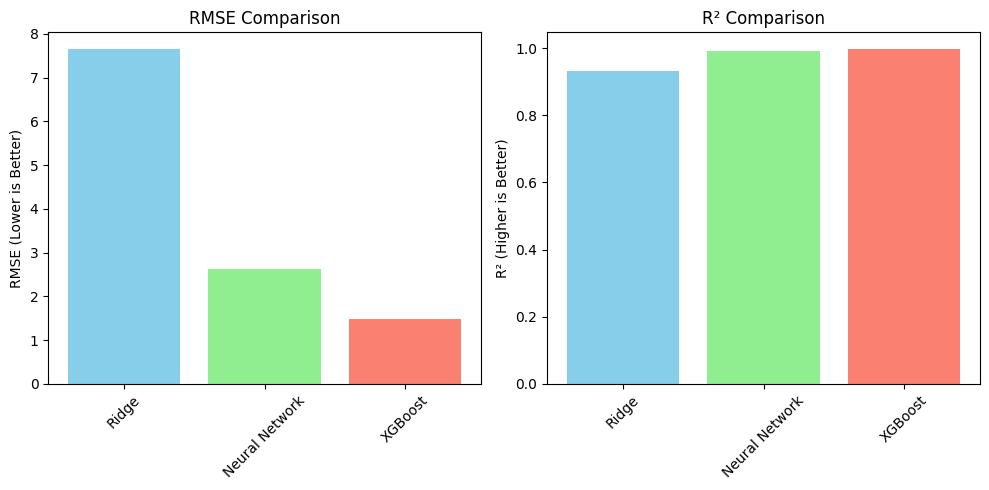

In [ ]:
print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE        = {metrics['RMSE']:.2f}")
    print(f"  R²          = {metrics['R2']:.4f}")
    print(f"  Params = {metrics['Params']}")

# %%
# Extract metrics
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
r2_values = [results[model]['R2'] for model in model_names]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('R² Comparison')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## **liver_disease Progression**

### Data Cleaning

In [ ]:
df = pd.read_csv("/content/liver_disease_progression_dataset_with_child_gender.csv")

print(df.info())
print(df.head())

#label encoding
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

# removing nulls
df.fillna(df.median(), inplace=True)

# removing duplicates
duplicate_count = df.duplicated().sum()
print(f" Found {duplicate_count} duplicate rows.")
df.drop_duplicates(inplace=True)

# removing outliers
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


output_file = "cleaned_tests(Liver).csv"
df.to_csv(output_file, index=False)

print(f" Cleaned data successfully {output_file}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   20000 non-null  object 
 1   Age                      20000 non-null  int64  
 2   PT_INR                   20000 non-null  float64
 3   GGT                      20000 non-null  float64
 4   Ammonia                  20000 non-null  float64
 5   Bilirubin                20000 non-null  float64
 6   Albumin                  20000 non-null  float64
 7   Creatinine               20000 non-null  float64
 8   ALT                      20000 non-null  float64
 9   AST                      20000 non-null  float64
 10  Platelet_Count           20000 non-null  float64
 11  Disease Progression (%)  20000 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.8+ MB
None
   Gender  Age    PT_INR        GGT    Ammonia  Bilirubin   Albumin

### Heatmaps for the whole dataset

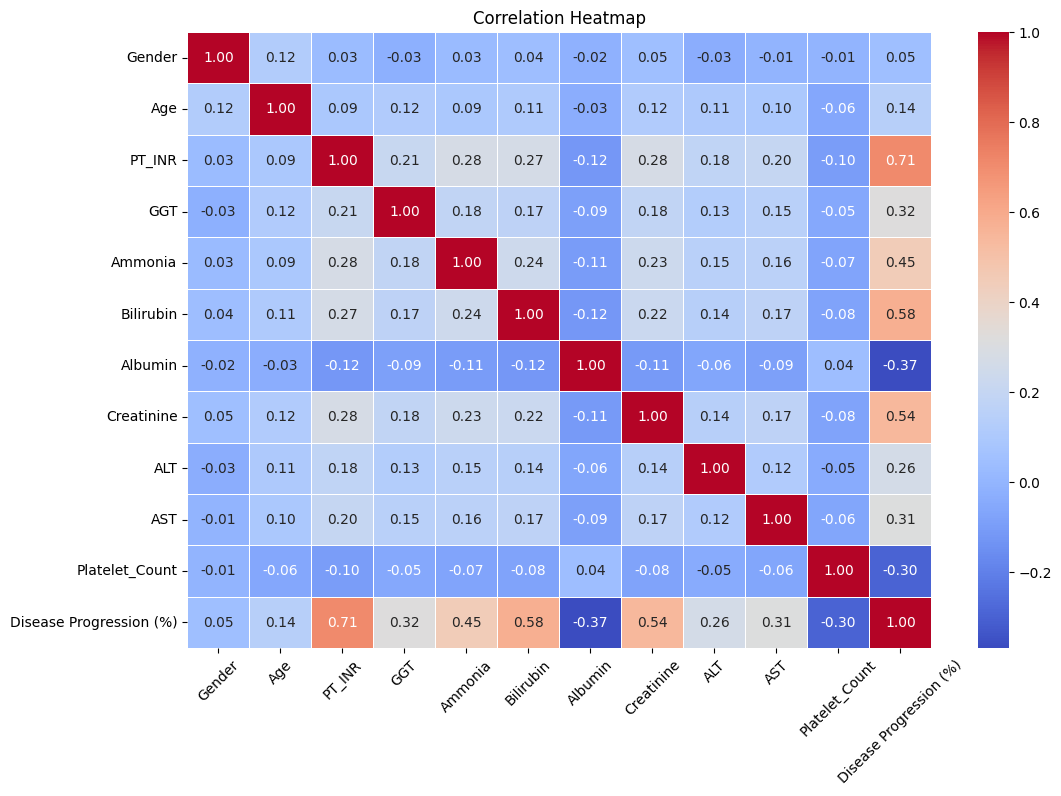

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

### Train-Test Split

In [ ]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

logger.info("Data has been split into training and testing sets.")

2025-05-08 16:03:35,028 - INFO - Data has been split into training and testing sets.


### Mini_Max Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

logger.info("Features are Scaled")

2025-05-08 16:03:40,887 - INFO - Features are Scaled


### Data Visualization

<Figure size 1600x1000 with 0 Axes>

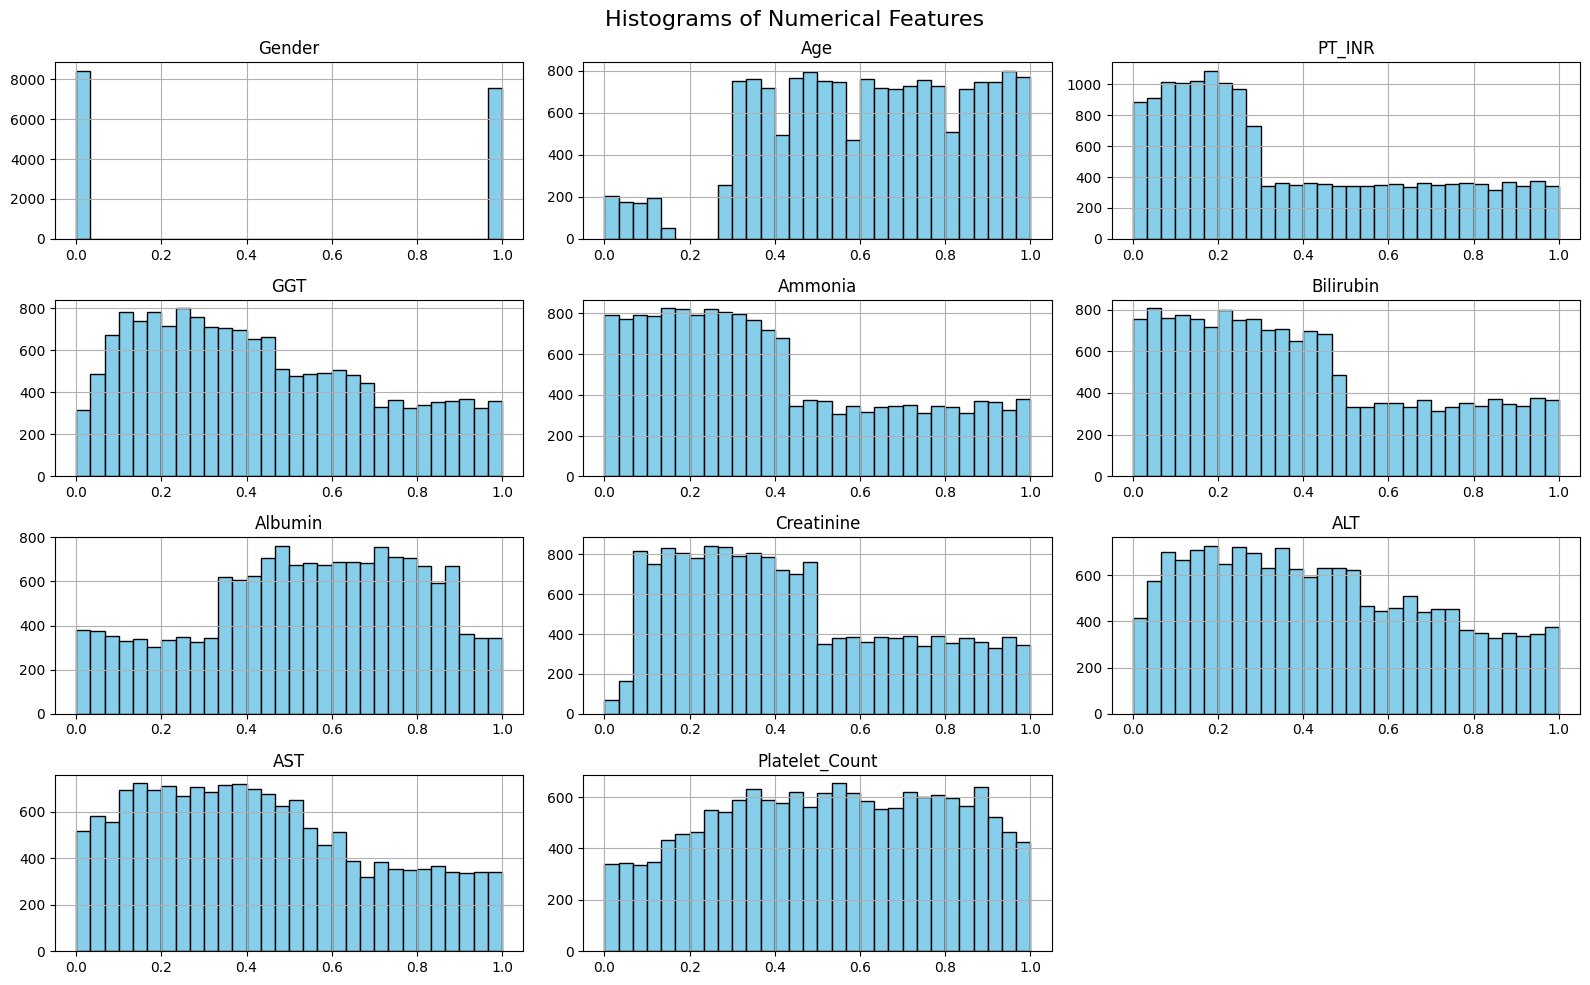

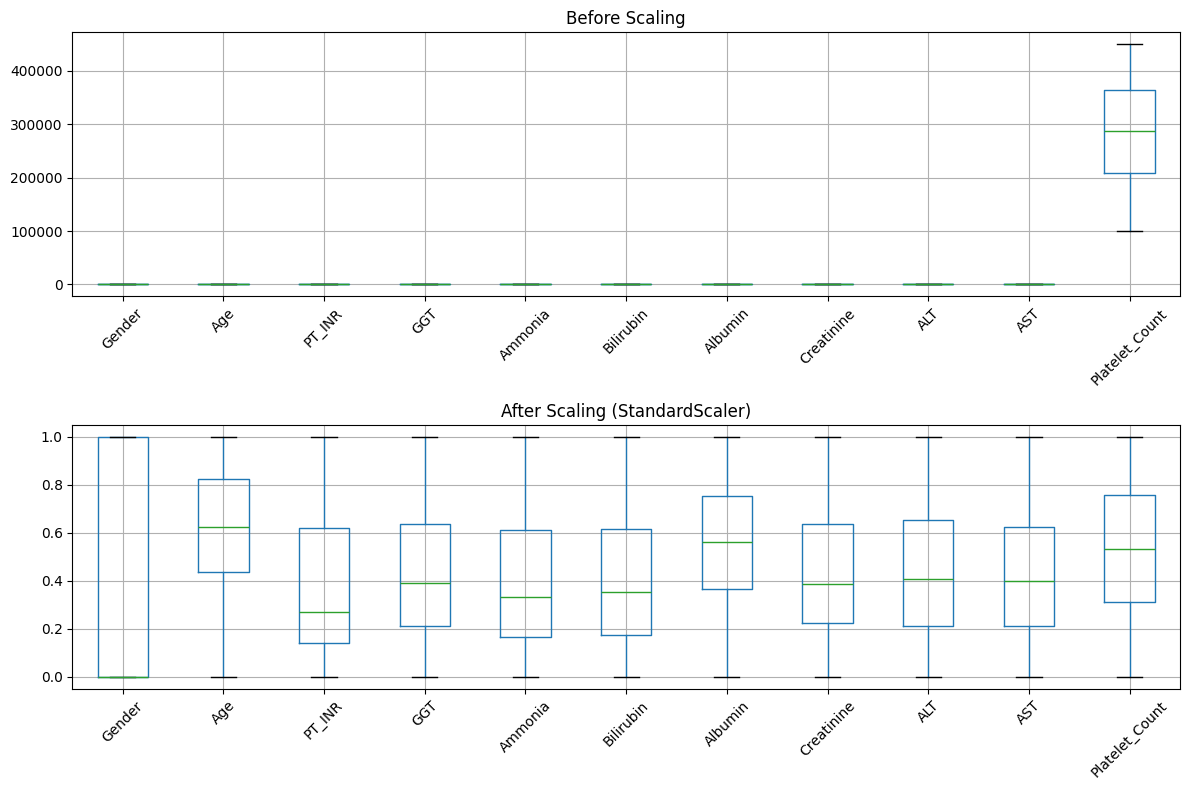

In [ ]:
plt.figure(figsize=(16, 10))
X_train_scaled.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Plot before and after scaling
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Before scaling
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

# After scaling
X_train_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Model Training and Evaluation

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

In [ ]:
# Store models and results to compare later
models = {}
results = {}

1. **Linear Regression with Ridge Regularization**

In [ ]:
# 1. Ridge Regression
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_pred_ridge = ridge_grid.predict(X_test)

models['Ridge'] = ridge_grid.best_estimator_
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge),
    'Params': ridge_grid.best_params_
}

logger.info(f"Ridge Regression evaluation complete. RMSE: {results['Ridge']['RMSE']:.4f}, R2: {results['Ridge']['R2']:.4f}, Best Params: {results['Ridge']['Params']}")


2025-05-08 16:04:03,736 - INFO - Ridge Regression evaluation complete. RMSE: 9.3778, R2: 0.8698, Best Params: {'alpha': 0.1}


2. **Neural Network**

In [ ]:
# --- Define NN Architecture ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

# --- Compile the Model ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse'])

# --- Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Extract Hyperparameters ---
def get_model_params(model):
    params = {}

    # Optimizer parameters
    if hasattr(model.optimizer, 'learning_rate'):
        params['learning_rate'] = float(model.optimizer.learning_rate.numpy())

    # Layer-specific parameters
    for layer in model.layers:
        if isinstance(layer, Dense):
            params[f'dense_units_{layer.name}'] = layer.units
            params[f'activation_{layer.name}'] = layer.activation.__name__
        elif isinstance(layer, Dropout):
            params[f'dropout_rate_{layer.name}'] = layer.rate
        elif isinstance(layer, BatchNormalization):
            params[f'batchnorm_{layer.name}'] = True

        return params

# --- Predict & Evaluate ---
y_pred_nn = model.predict(X_test).flatten()

# Store results
models['Neural Network'] = model
results['Neural Network'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'R2': r2_score(y_test, y_pred_nn),
    'Params': get_model_params(model)
}

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1444.9980 - mse: 1444.9980 - val_loss: 608.5887 - val_mse: 608.5887
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 486.1466 - mse: 486.1466 - val_loss: 142.4138 - val_mse: 142.4138
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 117.2219 - mse: 117.2219 - val_loss: 43.3887 - val_mse: 43.3887
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 77.3310 - mse: 77.3310 - val_loss: 30.6032 - val_mse: 30.6032
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 77.6233 - mse: 77.6233 - val_loss: 22.9464 - val_mse: 22.9464
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 72.7571 - mse: 72.7571 - val_loss: 21.3589 - val_mse: 21.3589
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 64.7026 - mse: 64.7026 - val_loss: 21.6057 - val_mse: 21.6057
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 63.9824 - mse: 63.9824 - val_loss: 21.1841 - val_mse: 21.1841
Epoch 9/50
400/400 ━━━━

3. **XGBoost Regressor**

In [ ]:
# 3. XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

models['XGBoost'] = grid_search.best_params_
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb),
    'Params': grid_search.best_params_
}

Fitting 3 folds for each of 72 candidates, totalling 216 fits


**Models Comparison**

Model Comparison:
Ridge:
  RMSE        = 9.38
  R²          = 0.8698
  Params = {'alpha': 0.1}
Neural Network:
  RMSE        = 3.82
  R²          = 0.9784
  Params = {'learning_rate': 0.0010000000474974513, 'dense_units_dense_14': 64, 'activation_dense_14': 'relu'}
XGBoost:
  RMSE        = 2.13
  R²          = 0.9933
  Params = {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


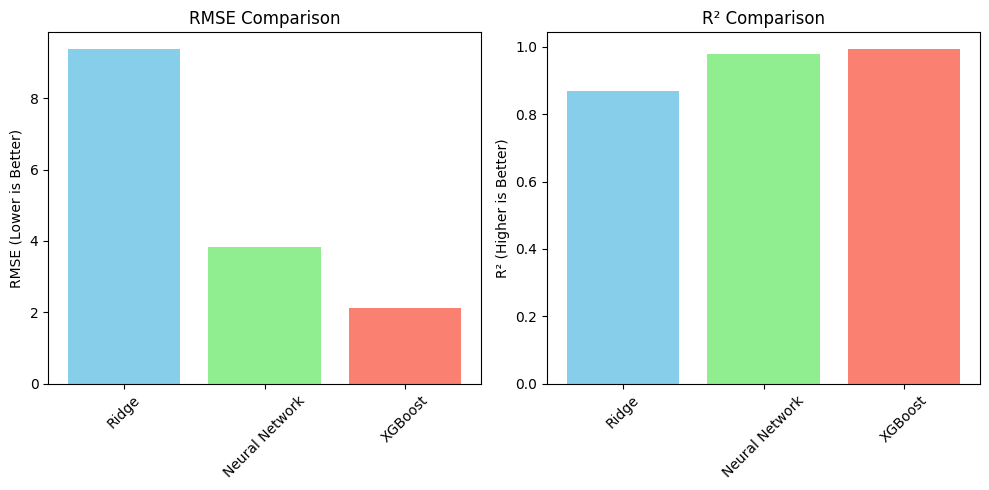

In [ ]:
print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE        = {metrics['RMSE']:.2f}")
    print(f"  R²          = {metrics['R2']:.4f}")
    print(f"  Params = {metrics['Params']}")

# Extract metrics
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
r2_values = [results[model]['R2'] for model in model_names]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('R² Comparison')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## **Heart_disease**

### Data Cleaning

In [ ]:
df = pd.read_csv("/content/Heart_Disease_progression_dataset_with_child_gender.csv")

print(df.info())
print(df.head())

#label encoding
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

# removing nulls
df.fillna(df.median(), inplace=True)

# removing duplicates
duplicate_count = df.duplicated().sum()
print(f" Found {duplicate_count} duplicate rows.")
df.drop_duplicates(inplace=True)

# removing outliers
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


output_file = "cleaned_tests(Heart).csv"
df.to_csv(output_file, index=False)

print(f" Cleaned data successfully {output_file}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     20000 non-null  int64  
 1   Gender                                  20000 non-null  object 
 2   LDL                                     20000 non-null  float64
 3   HDL                                     20000 non-null  float64
 4   Triglycerides                           20000 non-null  float64
 5   CRP                                     20000 non-null  float64
 6   ECG                                     20000 non-null  int64  
 7   Blood Pressure                          20000 non-null  float64
 8   Cholesterol                             20000 non-null  float64
 9   Troponin                                20000 non-null  float64
 10  BNP                                     20000 non-null  fl

### Heat Maps for the whole dataset

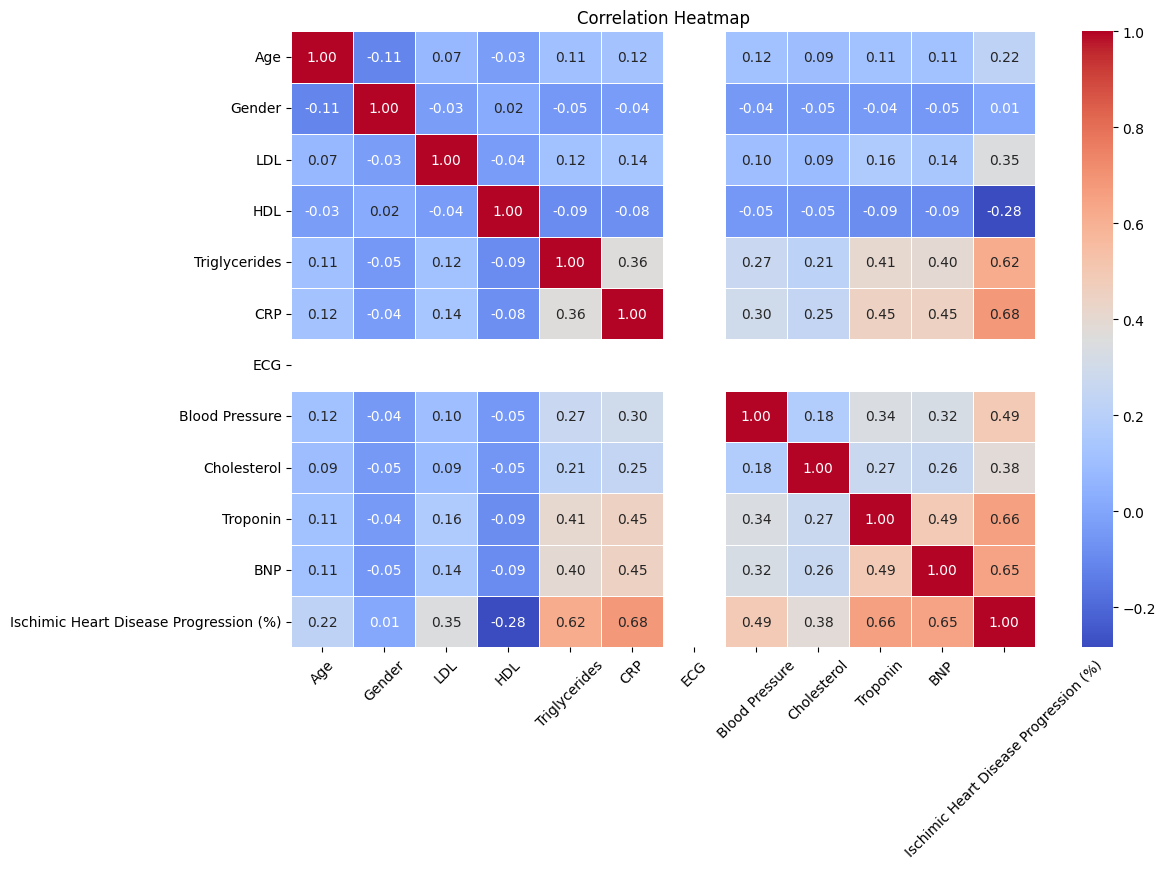

In [ ]:
#  Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

### Train-Test Split

In [ ]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

logger.info("Data has been split into training and testing sets.")

2025-05-08 16:04:33,806 - INFO - Data has been split into training and testing sets.


### Min_Max Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

logger.info("Features are Scaled")

2025-05-08 16:04:40,606 - INFO - Features are Scaled


### Data visualization

<Figure size 1600x1000 with 0 Axes>

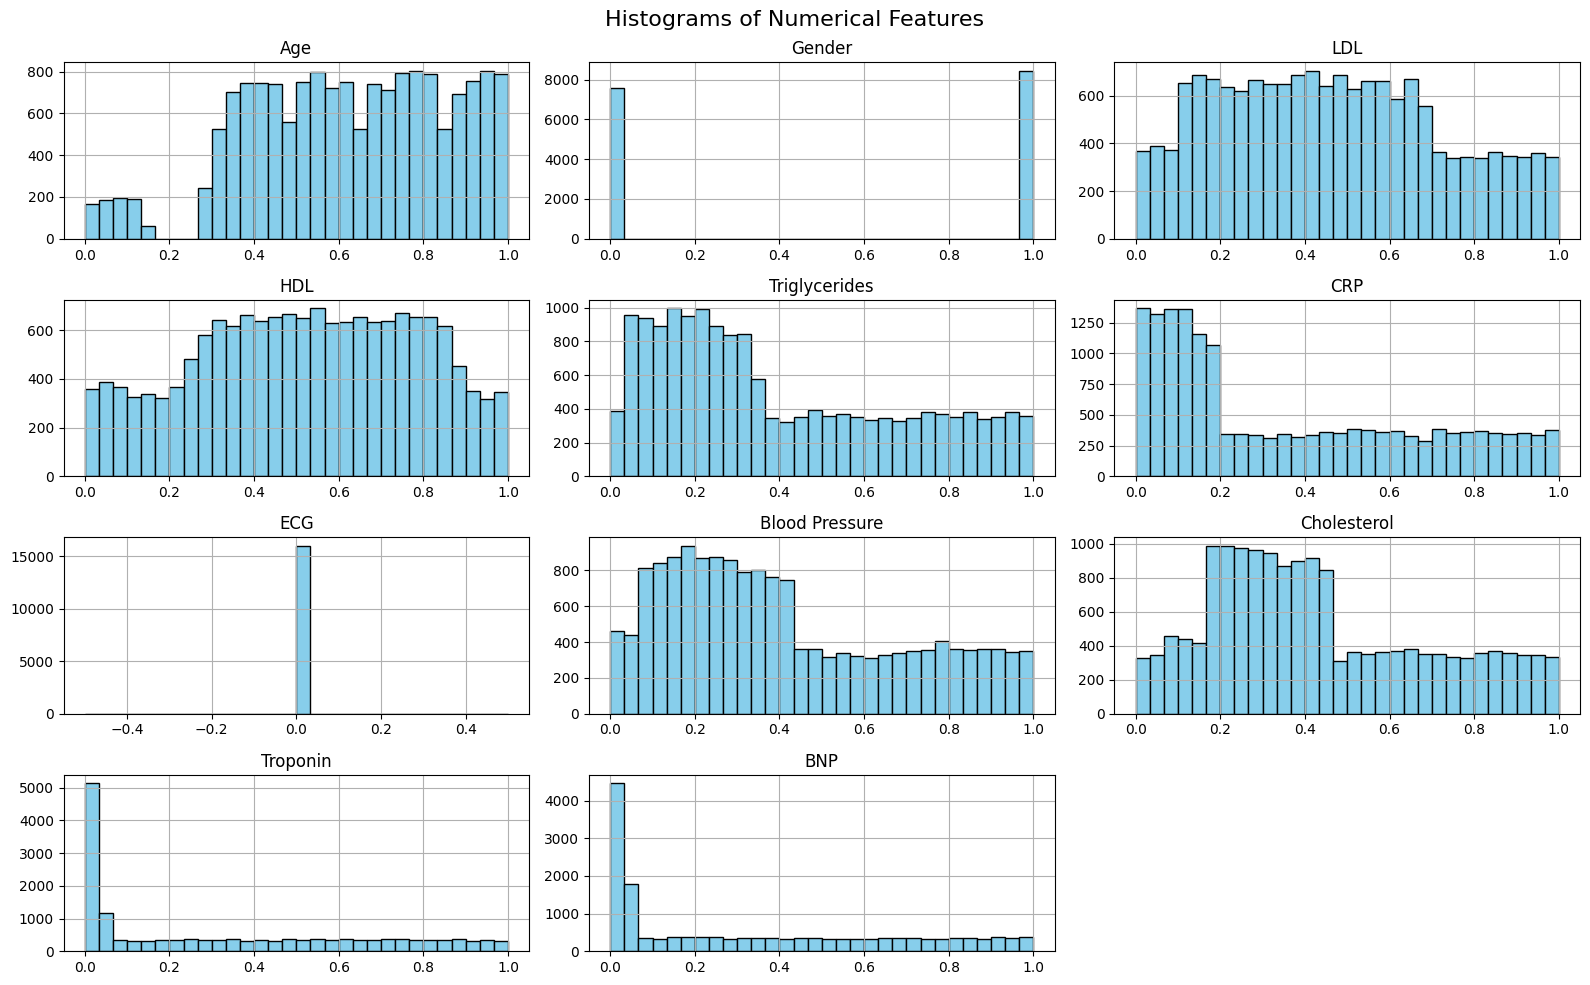

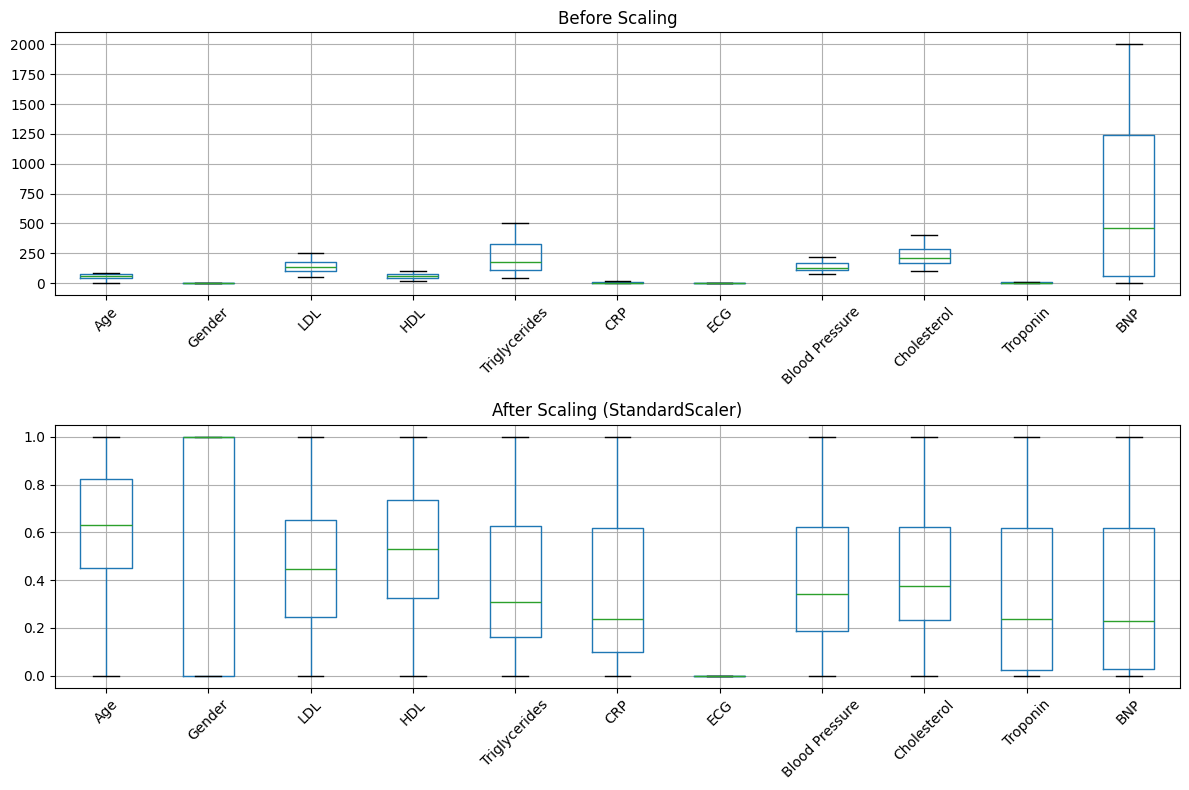

In [ ]:
plt.figure(figsize=(16, 10))
X_train_scaled.hist(figsize=(16, 10), bins=30, edgecolor='black', color='skyblue')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Plot before and after scaling
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Before scaling
X_train.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].tick_params(axis='x', rotation=45)

# After scaling
X_train_scaled.boxplot(ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Model Training and Evaluation

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

In [ ]:
# Store models and results to compare later
models = {}
results = {}

1. **Linear Regression with Ridge regularization**

In [ ]:
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_pred_ridge = ridge_grid.predict(X_test)

models['Ridge'] = ridge_grid.best_estimator_
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge),
    'Params': ridge_grid.best_params_
}

logger.info(f"Ridge Regression evaluation complete. RMSE: {results['Ridge']['RMSE']:.4f}, R2: {results['Ridge']['R2']:.4f}, Best Params: {results['Ridge']['Params']}")

2025-05-08 16:04:57,256 - INFO - Ridge Regression evaluation complete. RMSE: 11.3340, R2: 0.8552, Best Params: {'alpha': 1}


2. **Neural Network**

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Extract Hyperparameters
def get_model_params(model):
    params = {}

    # Optimizer parameters
    if hasattr(model.optimizer, 'learning_rate'):
        params['learning_rate'] = float(model.optimizer.learning_rate.numpy())

    # Layer-specific parameters
    for layer in model.layers:
        if isinstance(layer, Dense):
            params[f'dense_units_{layer.name}'] = layer.units
            params[f'activation_{layer.name}'] = layer.activation.__name__
        elif isinstance(layer, Dropout):
            params[f'dropout_rate_{layer.name}'] = layer.rate
        elif isinstance(layer, BatchNormalization):
            params[f'batchnorm_{layer.name}'] = True

        return params

# Predict & Evaluate
y_pred_nn = model.predict(X_test).flatten()

# Store results
models['Neural Network'] = model
results['Neural Network'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'R2': r2_score(y_test, y_pred_nn),
    'Params': get_model_params(model)
}

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1862.8135 - mse: 1862.8135 - val_loss: 827.4894 - val_mse: 827.4894
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 661.1460 - mse: 661.1460 - val_loss: 263.6336 - val_mse: 263.6336
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 209.7610 - mse: 209.7610 - val_loss: 55.0990 - val_mse: 55.0990
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 113.8728 - mse: 113.8728 - val_loss: 53.4861 - val_mse: 53.4861
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 105.5406 - mse: 105.5406 - val_loss: 53.0570 - val_mse: 53.0570
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 106.1163 - mse: 106.1163 - val_loss: 51.2633 - val_mse: 51.2633
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 103.7138 - mse: 103.7138 - val_loss: 52.4780 - val_mse: 52.4780
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 93.7962 - mse: 93.7962 - val_loss: 52.1359 - val_mse: 52.1359
Epoch 9/50
400/

3. **XGBoost Regressor**

In [ ]:
# 3. XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

models['XGBoost'] = grid_search.best_params_
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb),
    'Params': grid_search.best_params_
}

Fitting 3 folds for each of 72 candidates, totalling 216 fits


**Models Comparison**

Model Comparison:
Ridge:
  RMSE        = 11.33
  R²          = 0.8552
  Params = {'alpha': 1}
Neural Network:
  RMSE        = 6.71
  R²          = 0.9493
  Params = {'learning_rate': 0.0010000000474974513, 'dense_units_dense_17': 64, 'activation_dense_17': 'relu'}
XGBoost:
  RMSE        = 6.38
  R²          = 0.9541
  Params = {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


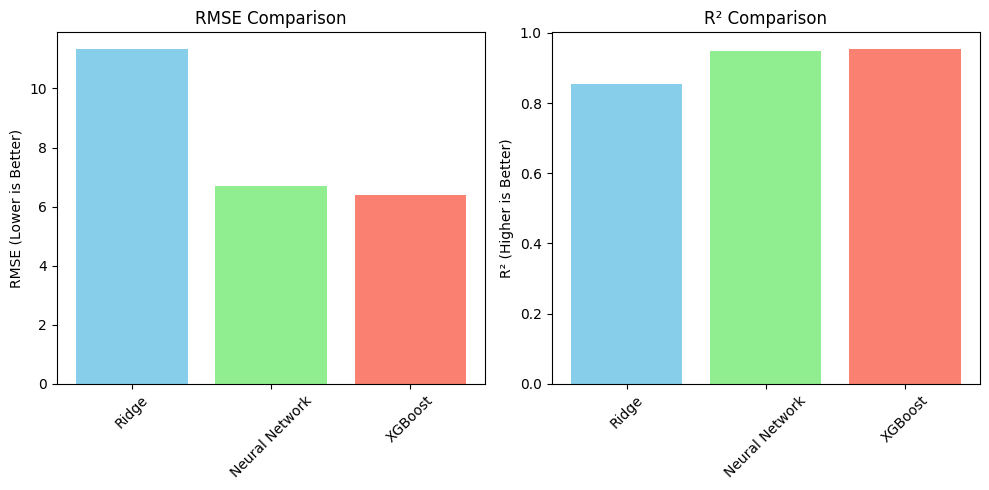

In [ ]:
print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE        = {metrics['RMSE']:.2f}")
    print(f"  R²          = {metrics['R2']:.4f}")
    print(f"  Params = {metrics['Params']}")

# Extract metrics
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
r2_values = [results[model]['R2'] for model in model_names]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('R² Comparison')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
